# **HMC**

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

d = 2
r = 3
n = 500
M = 100

E = np.zeros(M)
Q = np.zeros((M, 3))

# Фиксированные параметры
mu_0 = 0.0
mu_w_0 = 2.0
lambda_w_0 = 3.0
gamma_0 = 1.0
alpha_lambda = 1.0
beta_lambda = 1.0

t = 0
epsilon = 0.0017

# Логарифм функции правдоподобия
def loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X):
    Beta_Theta_w = tf.expand_dims(Beta_Theta_w, axis=1)
    model = (Beta_Theta_0 + tf.matmul(X, Beta_Theta_w)) + 0.5 * tf.reduce_sum((tf.matmul(X, Beta_v_matrix))**2 - (X**2) @ (Beta_v_matrix**2), axis=1, keepdims=True)
    loglik_1 = tf.reduce_sum(tf.expand_dims(y, axis=1) * model)
    loglik_0 = tf.reduce_sum(tf.math.log1p(tf.exp(model)))

    loglik = loglik_1 - loglik_0
    return loglik

# Логарифм априорного распределения для Theta_H
def log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new):
    log_lambda_w = tf.cast(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_w_new), tf.float64)
    log_mu_w = tf.cast(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0*Beta_lambda_w_new))).log_prob(Beta_mu_w_new), tf.float64)
    log_lambda_v = tf.cast(tf.reduce_sum(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_v_new)), tf.float64)
    log_mu_v = tf.reduce_sum(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0 * Beta_lambda_v_new))).log_prob(Beta_mu_v_new))

    log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
    return log_theta_H

# Логарифм априорного распределения для Theta
def log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new):
    log_theta_0 = tfp.distributions.Normal(loc=tf.cast(mu_w_0, tf.float64), scale=tf.sqrt(1/tf.cast(lambda_w_0, tf.float64))).log_prob(tf.cast(Beta_Theta_0, tf.float64))
    log_theta_w = tf.reduce_sum(tfp.distributions.Normal(loc=tf.cast(Beta_mu_w_new, tf.float64), scale=tf.sqrt(1/tf.cast(Beta_lambda_w_new, tf.float64))).log_prob(tf.cast(Beta_Theta_w, tf.float64)))
    log_theta_v = tf.reduce_sum(tfp.distributions.Normal(loc=Beta_mu_v_new, scale=tf.sqrt(1/Beta_lambda_v_new)).log_prob(Beta_v_matrix))

    log_theta = log_theta_0 + log_theta_w + log_theta_v
    return log_theta


for N in [50]:
    for m in range(M):
        X = np.random.randn(n, d)
        # Параметры
        w_0 = np.random.normal(mu_w_0, np.sqrt(1/lambda_w_0))
        lambda_w = np.random.gamma(alpha_lambda, 1/beta_lambda)
        mu_w = np.random.normal(mu_0, np.sqrt(1/(gamma_0*lambda_w)))
        w = np.random.normal(mu_w, np.sqrt(1/lambda_w), d)
        lambda_v = np.random.gamma(alpha_lambda, 1/beta_lambda, r)
        mu_v = np.random.normal(mu_0, np.sqrt(1/(gamma_0*lambda_v)), r)
        v = np.random.normal(mu_v, np.sqrt(1/lambda_v), (d, r))

        # Beta_teor
        Beta_teor = np.concatenate((np.array([w_0]), w, v.flatten(), np.array([lambda_w, mu_w]), lambda_v, mu_v))
        Beta_teor = tf.expand_dims(tf.constant(Beta_teor, dtype=tf.float64), axis=0)

        doudle_Sum_teor = 0.5 * np.sum((X @ v)**2 - (X**2) @ (v**2), axis=1)
        p = expit(w_0 + X @ w + doudle_Sum_teor)
        y = np.random.binomial(1, p, n).astype(np.float64)

        mu_w_new = 0
        mu_v_new = np.zeros(r)
        lambda_w_new = 1
        lambda_v_new = np.ones(r)

        Theta_0 = 0
        Theta_w = np.zeros(d)
        Theta_v = np.zeros(d*r)
        Beta = np.concatenate((np.array([Theta_0]), Theta_w, Theta_v, np.array([lambda_w_new, mu_w_new]), lambda_v_new, mu_v_new))
        Beta = tf.expand_dims(tf.constant(Beta, dtype=tf.float64), axis=0)
        Theta_v_matrix = tf.constant(np.reshape(Theta_v, (d, r)), dtype=tf.float64)

        def log_prob_fn(Beta):
          # Логарифм функции правдоподобия для Beta
          loglik_Beta = loglik(Beta[0], Beta[1:d+1], Theta_v_matrix, y, X)
          # Логарифм априорного распределения для Theta_H для Beta
          log_theta_H_Beta = log_theta_H(lambda_w_new , alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
          # Логарифм априорного распределения для Theta для Beta
          log_theta_Beta = log_theta(Beta[0], mu_w_0, lambda_w_0, Beta[1:d+1], mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

          # Логарифм апостериорного распределения для Beta
          logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta
          return logpost_Beta

        # Параметры HMC
        step_size = epsilon
        num_burnin_steps = 0
        num_adaptation_steps = int(0.8 * num_burnin_steps)
        num_samples = N

        def run_sampler():
            initial_state = tf.zeros(1 + d + d*r + 2 + 2*r, dtype=tf.float64)
            # HMC ядро
            hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
                target_log_prob_fn=log_prob_fn,
                step_size=step_size,
                num_leapfrog_steps=10)

            # Адаптивный HMC
            adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
                inner_kernel=hmc_kernel,
                num_adaptation_steps=num_adaptation_steps,
                target_accept_prob=0.8)

            samples = tfp.mcmc.sample_chain(
                num_results=num_samples,
                num_burnin_steps=num_burnin_steps,
                current_state=initial_state,
                kernel=adaptive_hmc,
                trace_fn=None)
            return samples

       # Запуск сессии и получение значений сэмплов
        samples = run_sampler()
        b_1 = np.mean(np.asarray(samples), axis=0)
        E[m] = np.sqrt(np.sum((Beta_teor - b_1)**2))

    Q[:, t] = E
    t += 1

# Создание boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(Q, patch_artist=True)

# Отображение графика
plt.show()


# **HMC (небольшая размерность)**

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

d = 2
r = 3
n = 500
M = 1

E = np.zeros(M)
Q = np.zeros((M, 3))

# Фиксированные параметры
mu_0 = 0.0
mu_w_0 = 2.0
lambda_w_0 = 3.0
gamma_0 = 1.0
alpha_lambda = 1.0
beta_lambda = 1.0

t = 0
epsilon = 0.0017

# Логарифм функции правдоподобия
def loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X):
    Beta_Theta_w = tf.expand_dims(Beta_Theta_w, axis=1)
    model = (Beta_Theta_0 + tf.matmul(X, Beta_Theta_w)) + 0.5 * tf.reduce_sum((tf.matmul(X, Beta_v_matrix))**2 - (X**2) @ (Beta_v_matrix**2), axis=1, keepdims=True)
    loglik_1 = tf.reduce_sum(tf.expand_dims(y, axis=1) * model)
    loglik_0 = tf.reduce_sum(tf.math.log1p(tf.exp(model)))

    loglik = loglik_1 - loglik_0
    return loglik

# Логарифм априорного распределения для Theta_H
def log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new):
    log_lambda_w = tf.cast(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_w_new), tf.float64)
    log_mu_w = tf.cast(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0*Beta_lambda_w_new))).log_prob(Beta_mu_w_new), tf.float64)
    log_lambda_v = tf.cast(tf.reduce_sum(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_v_new)), tf.float64)
    log_mu_v = tf.reduce_sum(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0 * Beta_lambda_v_new))).log_prob(Beta_mu_v_new))

    log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
    return log_theta_H

# Логарифм априорного распределения для Theta
def log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new):
    log_theta_0 = tfp.distributions.Normal(loc=tf.cast(mu_w_0, tf.float64), scale=tf.sqrt(1/tf.cast(lambda_w_0, tf.float64))).log_prob(tf.cast(Beta_Theta_0, tf.float64))
    log_theta_w = tf.reduce_sum(tfp.distributions.Normal(loc=tf.cast(Beta_mu_w_new, tf.float64), scale=tf.sqrt(1/tf.cast(Beta_lambda_w_new, tf.float64))).log_prob(tf.cast(Beta_Theta_w, tf.float64)))
    log_theta_v = tf.reduce_sum(tfp.distributions.Normal(loc=Beta_mu_v_new, scale=tf.sqrt(1/Beta_lambda_v_new)).log_prob(Beta_v_matrix))

    log_theta = log_theta_0 + log_theta_w + log_theta_v
    return log_theta


for N in [1]:
    for m in range(M):
        X = np.random.randn(n, d)
        # Параметры
        w_0 = np.random.normal(mu_w_0, np.sqrt(1/lambda_w_0))
        lambda_w = np.random.gamma(alpha_lambda, 1/beta_lambda)
        mu_w = np.random.normal(mu_0, np.sqrt(1/(gamma_0*lambda_w)))
        w = np.random.normal(mu_w, np.sqrt(1/lambda_w), d)
        lambda_v = np.random.gamma(alpha_lambda, 1/beta_lambda, r)
        mu_v = np.random.normal(mu_0, np.sqrt(1/(gamma_0*lambda_v)), r)
        v = np.random.normal(mu_v, np.sqrt(1/lambda_v), (d, r))

        # Beta_teor
        Beta_teor = np.concatenate((np.array([w_0]), w, v.flatten(), np.array([lambda_w, mu_w]), lambda_v, mu_v))
        Beta_teor = tf.expand_dims(tf.constant(Beta_teor, dtype=tf.float64), axis=0)

        doudle_Sum_teor = 0.5 * np.sum((X @ v)**2 - (X**2) @ (v**2), axis=1)
        p = expit(w_0 + X @ w + doudle_Sum_teor)
        y = np.random.binomial(1, p, n).astype(np.float64)

        mu_w_new = 0
        mu_v_new = np.zeros(r)
        lambda_w_new = 1
        lambda_v_new = np.ones(r)

        Theta_0 = 0
        Theta_w = np.zeros(d)
        Theta_v = np.zeros(d*r)
        Beta = np.concatenate((np.array([Theta_0]), Theta_w, Theta_v, np.array([lambda_w_new, mu_w_new]), lambda_v_new, mu_v_new))
        Beta = tf.expand_dims(tf.constant(Beta, dtype=tf.float64), axis=0)
        Theta_v_matrix = tf.constant(np.reshape(Theta_v, (d, r)), dtype=tf.float64)

        def log_prob_fn(Beta):
          # Логарифм функции правдоподобия для Beta
          loglik_Beta = loglik(Beta[0], Beta[1:d+1], Theta_v_matrix, y, X)
          # Логарифм априорного распределения для Theta_H для Beta
          log_theta_H_Beta = log_theta_H(lambda_w_new , alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
          # Логарифм априорного распределения для Theta для Beta
          log_theta_Beta = log_theta(Beta[0], mu_w_0, lambda_w_0, Beta[1:d+1], mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

          # Логарифм апостериорного распределения для Beta
          logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta
          return logpost_Beta

        # Параметры HMC
        step_size = epsilon
        num_burnin_steps = 0
        num_adaptation_steps = int(0.8 * num_burnin_steps)
        num_samples = N

        def run_sampler():
            initial_state = tf.zeros(1 + d + d*r + 2 + 2*r, dtype=tf.float64)
            # HMC ядро
            hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
                target_log_prob_fn=log_prob_fn,
                step_size=step_size,
                num_leapfrog_steps=10)

            # Адаптивный HMC
            adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
                inner_kernel=hmc_kernel,
                num_adaptation_steps=num_adaptation_steps,
                target_accept_prob=0.8)

            samples = tfp.mcmc.sample_chain(
                num_results=num_samples,
                num_burnin_steps=num_burnin_steps,
                current_state=initial_state,
                kernel=adaptive_hmc,
                trace_fn=None)
            return samples

       # Запуск сессии и получение значений сэмплов
        samples = run_sampler()
        b_1 = np.mean(np.asarray(samples), axis=0)
        E[m] = np.sqrt(np.sum((Beta_teor - b_1)**2))

    Q[:, t] = E
    t += 1

print(samples)
print("Среднее по матрице", b_1)

tf.Tensor(
[[ 0.02877464 -0.02632524 -0.02927556  0.01633519  0.01607479  0.0191727
  -0.020927   -0.01215239  0.02974364  0.0239055   0.01314477 -0.01060812
   0.02245453  0.0206424   0.02704498  0.0088749  -0.00053334]], shape=(1, 17), dtype=float64)
Среднее по матрице [ 0.02877464 -0.02632524 -0.02927556  0.01633519  0.01607479  0.0191727
 -0.020927   -0.01215239  0.02974364  0.0239055   0.01314477 -0.01060812
  0.02245453  0.0206424   0.02704498  0.0088749  -0.00053334]


# **Datasets (HMC)**

**Pima Indians Diabetes Dataset**

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
import pandas as pd
from sklearn.metrics import roc_auc_score


data = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv", header=None)
data_matrix = data.values

X = data_matrix[1:501, :8]
y = data_matrix[1:501, 8]
y = np.squeeze(y)

d = X.shape[1]

n = 500
r = 3
N = 100

# Фиксированные параметры
mu_0 = 0.0
mu_w_0 = 2.0
lambda_w_0 = 3.0
gamma_0 = 1.0
alpha_lambda = 1.0
beta_lambda = 1.0

epsilon = 0.00006

mu_w_new = 0
mu_v_new = np.zeros(r)
lambda_w_new = 1
lambda_v_new = np.ones(r)

Theta_0 = 0
Theta_w = np.zeros(d)
Theta_v = np.zeros(d*r)
Beta = np.concatenate((np.array([Theta_0]), Theta_w, Theta_v, np.array([lambda_w_new, mu_w_new]), lambda_v_new, mu_v_new))
Beta = tf.expand_dims(tf.constant(Beta, dtype=tf.float64), axis=0)
Theta_v_matrix = tf.constant(np.reshape(Theta_v, (d, r)), dtype=tf.float64)


# Логарифм функции правдоподобия
def loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X):
    Beta_Theta_w = tf.expand_dims(Beta_Theta_w, axis=1)
    model = (Beta_Theta_0 + tf.matmul(X, Beta_Theta_w)) + 0.5 * tf.reduce_sum((tf.matmul(X, Beta_v_matrix))**2 - (X**2) @ (Beta_v_matrix**2), axis=1, keepdims=True)
    loglik_1 = tf.reduce_sum(tf.expand_dims(y, axis=1) * model)
    loglik_0 = tf.reduce_sum(tf.math.log1p(tf.exp(model)))

    loglik = loglik_1 - loglik_0
    return loglik

# Логарифм априорного распределения для Theta_H
def log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new):
    log_lambda_w = tf.cast(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_w_new), tf.float64)
    log_mu_w = tf.cast(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0*Beta_lambda_w_new))).log_prob(Beta_mu_w_new), tf.float64)
    log_lambda_v = tf.cast(tf.reduce_sum(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_v_new)), tf.float64)
    log_mu_v = tf.reduce_sum(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0 * Beta_lambda_v_new))).log_prob(Beta_mu_v_new))

    log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
    return log_theta_H

# Логарифм априорного распределения для Theta
def log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new):
    log_theta_0 = tfp.distributions.Normal(loc=tf.cast(mu_w_0, tf.float64), scale=tf.sqrt(1/tf.cast(lambda_w_0, tf.float64))).log_prob(tf.cast(Beta_Theta_0, tf.float64))
    log_theta_w = tf.reduce_sum(tfp.distributions.Normal(loc=tf.cast(Beta_mu_w_new, tf.float64), scale=tf.sqrt(1/tf.cast(Beta_lambda_w_new, tf.float64))).log_prob(tf.cast(Beta_Theta_w, tf.float64)))
    log_theta_v = tf.reduce_sum(tfp.distributions.Normal(loc=Beta_mu_v_new, scale=tf.sqrt(1/Beta_lambda_v_new)).log_prob(Beta_v_matrix))

    log_theta = log_theta_0 + log_theta_w + log_theta_v
    return log_theta


def log_prob_fn(Beta):
  # Логарифм функции правдоподобия для Beta
  loglik_Beta = loglik(Beta[0], Beta[1:d+1], Theta_v_matrix, y, X)
  # Логарифм априорного распределения для Theta_H для Beta
  log_theta_H_Beta = log_theta_H(lambda_w_new , alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
  # Логарифм априорного распределения для Theta для Beta
  log_theta_Beta = log_theta(Beta[0], mu_w_0, lambda_w_0, Beta[1:d+1], mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

  # Логарифм апостериорного распределения для Beta
  logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta

  return logpost_Beta

# Параметры HMC
step_size = epsilon
num_burnin_steps = 0
num_adaptation_steps = int(0.8 * num_burnin_steps)
num_samples = N

def run_sampler():
    initial_state = tf.zeros(1 + d + d*r + 2 + 2*r, dtype=tf.float64)
    # HMC ядро
    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=log_prob_fn,
        step_size=step_size,
        num_leapfrog_steps=10)

    # Адаптивный HMC
    adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=hmc_kernel,
        num_adaptation_steps=num_adaptation_steps,
        target_accept_prob=0.8)

    samples = tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        kernel=adaptive_hmc,
        trace_fn=None)
    return samples

# Запуск сессии и получение значений сэмплов
samples = run_sampler()
b_1 = np.mean(np.asarray(samples), axis=0)
V = np.matrix(b_1[(d + 1):(d + 1 + d * r)]).reshape(d, r, order='C')

X1 = data_matrix[501:768, :8]
y1 = data_matrix[501:768, 8]

D = 0.5 * tf.reduce_sum((tf.matmul(X1, V))**2 - (X1**2) @ np.square(V), axis=1, keepdims=True)
b_1 = tf.expand_dims(tf.constant(b_1, dtype=tf.float64), axis=1)
prob = 1 /(1 + tf.exp(-(b_1[0] + tf.matmul(X1, b_1[1:(d+1)]) + D)))

auc_roc = roc_auc_score(y1, prob)
print("AUC-ROC:", auc_roc)


AUC-ROC: 0.5468328408068869


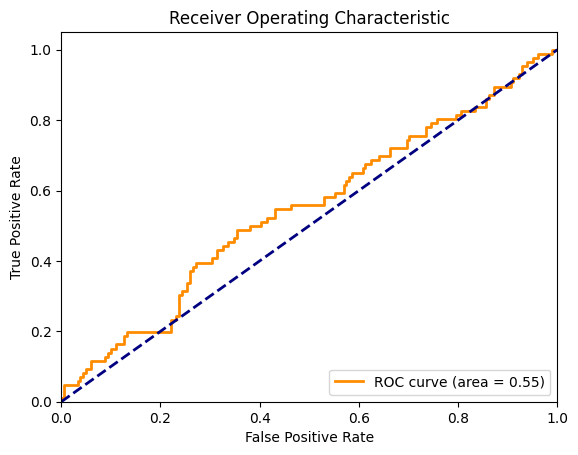

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y1, prob)
roc_auc = auc(fpr, tpr)

# Построение ROC кривой
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

**Sonar Dataset**

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
import pandas as pd
from sklearn.metrics import roc_auc_score

data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data", header=None)
ind = np.random.permutation(207)
data = data.iloc[ind]

n = 120
r = 2
N = 100

data_new = data.iloc[:121, :]
X = data_new .iloc[1:, :60].values  # Первые n строк и первые 60 столбцов, преобразуем в numpy array
y = (data_new .iloc[1:, 60] == 'R').astype(np.float64).values

d = X.shape[1]

# Фиксированные параметры
mu_0 = 0.0
mu_w_0 = 2.0
lambda_w_0 = 3.0
gamma_0 = 1.0
alpha_lambda = 1.0
beta_lambda = 1.0

epsilon = 0.001

mu_w_new = 0
mu_v_new = np.zeros(r)
lambda_w_new = 1
lambda_v_new = np.ones(r)

Theta_0 = 0
Theta_w = np.zeros(d)
Theta_v = np.zeros(d*r)
Beta = np.concatenate((np.array([Theta_0]), Theta_w, Theta_v, np.array([lambda_w_new, mu_w_new]), lambda_v_new, mu_v_new))
Beta = tf.expand_dims(tf.constant(Beta, dtype=tf.float64), axis=0)
Theta_v_matrix = tf.constant(np.reshape(Theta_v, (d, r)), dtype=tf.float64)


# Логарифм функции правдоподобия
def loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X):
    Beta_Theta_w = tf.expand_dims(Beta_Theta_w, axis=1)
    model = (Beta_Theta_0 + tf.matmul(X, Beta_Theta_w)) + 0.5 * tf.reduce_sum((tf.matmul(X, Beta_v_matrix))**2 - (X**2) @ (Beta_v_matrix**2), axis=1, keepdims=True)

    loglik_1 = tf.reduce_sum(tf.expand_dims(y, axis=1) * model)
    loglik_0 = tf.reduce_sum(tf.math.log1p(tf.exp(model)))

    loglik = loglik_1 - loglik_0
    return loglik

# Логарифм априорного распределения для Theta_H
def log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new):
    log_lambda_w = tf.cast(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_w_new), tf.float64)
    log_mu_w = tf.cast(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0*Beta_lambda_w_new))).log_prob(Beta_mu_w_new), tf.float64)
    log_lambda_v = tf.cast(tf.reduce_sum(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_v_new)), tf.float64)
    log_mu_v = tf.reduce_sum(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0 * Beta_lambda_v_new))).log_prob(Beta_mu_v_new))

    log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
    return log_theta_H

# Логарифм априорного распределения для Theta
def log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new):
    log_theta_0 = tfp.distributions.Normal(loc=tf.cast(mu_w_0, tf.float64), scale=tf.sqrt(1/tf.cast(lambda_w_0, tf.float64))).log_prob(tf.cast(Beta_Theta_0, tf.float64))
    log_theta_w = tf.reduce_sum(tfp.distributions.Normal(loc=tf.cast(Beta_mu_w_new, tf.float64), scale=tf.sqrt(1/tf.cast(Beta_lambda_w_new, tf.float64))).log_prob(tf.cast(Beta_Theta_w, tf.float64)))
    log_theta_v = tf.reduce_sum(tfp.distributions.Normal(loc=Beta_mu_v_new, scale=tf.sqrt(1/Beta_lambda_v_new)).log_prob(Beta_v_matrix))

    log_theta = log_theta_0 + log_theta_w + log_theta_v
    return log_theta


def log_prob_fn(Beta):
  # Логарифм функции правдоподобия для Beta
  loglik_Beta = loglik(Beta[0], Beta[1:d+1], Theta_v_matrix, y, X)
  # Логарифм априорного распределения для Theta_H для Beta
  log_theta_H_Beta = log_theta_H(lambda_w_new , alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
  # Логарифм априорного распределения для Theta для Beta
  log_theta_Beta = log_theta(Beta[0], mu_w_0, lambda_w_0, Beta[1:d+1], mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

  # Логарифм апостериорного распределения для Beta
  logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta
  return logpost_Beta

# Параметры HMC
step_size = epsilon
num_burnin_steps = 0
num_adaptation_steps = int(0.8 * num_burnin_steps)
num_samples = N

def run_sampler():
    initial_state = tf.zeros(1 + d + d*r + 2 + 2*r, dtype=tf.float64)
    # HMC ядро
    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=log_prob_fn,
        step_size=step_size,
        num_leapfrog_steps=10)

    # Адаптивный HMC
    adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=hmc_kernel,
        num_adaptation_steps=num_adaptation_steps,
        target_accept_prob=0.8)

    samples = tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        kernel=adaptive_hmc,
        trace_fn=None)
    return samples

# Запуск сессии и получение значений сэмплов
samples = run_sampler()
b_1 = np.mean(np.asarray(samples), axis=0)
V = np.matrix(b_1[(d + 1):(d + 1 + d * r)]).reshape(d, r, order='C')

X1 = data.iloc[121:208, :60].values
X1 = np.matrix(X1)
y1 = (data.iloc[121:208, 60] == 'R').astype(np.float64).values
y1 = np.array(y1)


D = 0.5 * tf.reduce_sum((tf.matmul(X1, V))**2 - np.square(X1) @ np.square(V), axis=1, keepdims=True)
b_1 = tf.expand_dims(tf.constant(b_1, dtype=tf.float64), axis=1)
prob = 1 /(1 + tf.exp(-(b_1[0] + tf.matmul(X1, b_1[1:(d+1)]) + D)))

auc_roc = roc_auc_score(y1, prob)
print("AUC-ROC:", auc_roc)

AUC-ROC: 0.6872294372294373


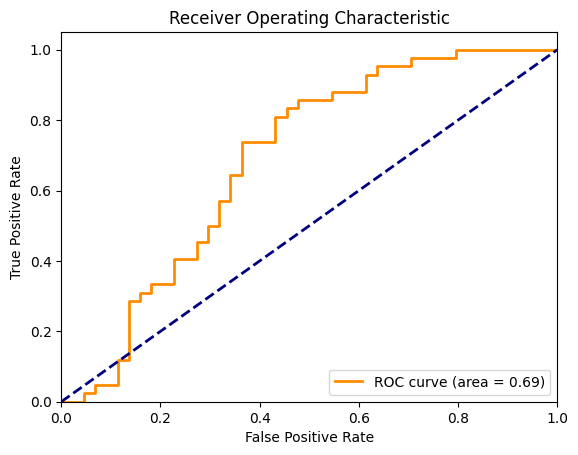

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y1, prob)
roc_auc = auc(fpr, tpr)

# Построение ROC кривой
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

**Australian Credit Approval DataSet**

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
import pandas as pd
from sklearn.metrics import roc_auc_score

data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/australian/australian.dat"
data = pd.read_csv(data_url, sep=' ', header=None, na_values='?', skipinitialspace=True)
data = data.dropna().values

n = 500
y = data[1:501, 14]
X = data[1:501, :14]

r = 3
N = 100

d = X.shape[1]

# Фиксированные параметры
mu_0 = 0.0
mu_w_0 = 2.0
lambda_w_0 = 3.0
gamma_0 = 1.0
alpha_lambda = 1.0
beta_lambda = 1.0

epsilon = 0.000001

mu_w_new = 0
mu_v_new = np.zeros(r)
lambda_w_new = 1
lambda_v_new = np.ones(r)

Theta_0 = 0
Theta_w = np.zeros(d)
Theta_v = np.zeros(d*r)
Beta = np.concatenate((np.array([Theta_0]), Theta_w, Theta_v, np.array([lambda_w_new, mu_w_new]), lambda_v_new, mu_v_new))
Beta = tf.expand_dims(tf.constant(Beta, dtype=tf.float64), axis=0)
Theta_v_matrix = tf.constant(np.reshape(Theta_v, (d, r)), dtype=tf.float64)


# Логарифм функции правдоподобия
def loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X):
    Beta_Theta_w = tf.expand_dims(Beta_Theta_w, axis=1)
    model = (Beta_Theta_0 + tf.matmul(X, Beta_Theta_w)) + 0.5 * tf.reduce_sum((tf.matmul(X, Beta_v_matrix))**2 - (X**2) @ (Beta_v_matrix**2), axis=1, keepdims=True)

    loglik_1 = tf.reduce_sum(tf.expand_dims(y, axis=1) * model)
    loglik_0 = tf.reduce_sum(tf.math.log1p(tf.exp(model)))

    loglik = loglik_1 - loglik_0
    return loglik

# Логарифм априорного распределения для Theta_H
def log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new):
    log_lambda_w = tf.cast(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_w_new), tf.float64)
    log_mu_w = tf.cast(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0*Beta_lambda_w_new))).log_prob(Beta_mu_w_new), tf.float64)
    log_lambda_v = tf.cast(tf.reduce_sum(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_v_new)), tf.float64)
    log_mu_v = tf.reduce_sum(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0 * Beta_lambda_v_new))).log_prob(Beta_mu_v_new))

    log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
    return log_theta_H

# Логарифм априорного распределения для Theta
def log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new):
    log_theta_0 = tfp.distributions.Normal(loc=tf.cast(mu_w_0, tf.float64), scale=tf.sqrt(1/tf.cast(lambda_w_0, tf.float64))).log_prob(tf.cast(Beta_Theta_0, tf.float64))
    log_theta_w = tf.reduce_sum(tfp.distributions.Normal(loc=tf.cast(Beta_mu_w_new, tf.float64), scale=tf.sqrt(1/tf.cast(Beta_lambda_w_new, tf.float64))).log_prob(tf.cast(Beta_Theta_w, tf.float64)))
    log_theta_v = tf.reduce_sum(tfp.distributions.Normal(loc=Beta_mu_v_new, scale=tf.sqrt(1/Beta_lambda_v_new)).log_prob(Beta_v_matrix))

    log_theta = log_theta_0 + log_theta_w + log_theta_v
    return log_theta


def log_prob_fn(Beta):
  # Логарифм функции правдоподобия для Beta
  loglik_Beta = loglik(Beta[0], Beta[1:d+1], Theta_v_matrix, y, X)
  # Логарифм априорного распределения для Theta_H для Beta
  log_theta_H_Beta = log_theta_H(lambda_w_new , alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
  # Логарифм априорного распределения для Theta для Beta
  log_theta_Beta = log_theta(Beta[0], mu_w_0, lambda_w_0, Beta[1:d+1], mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

  # Логарифм апостериорного распределения для Beta
  logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta

  return logpost_Beta

# Параметры HMC
step_size = epsilon
num_burnin_steps = 0
num_adaptation_steps = int(0.8 * num_burnin_steps)
num_samples = N

def run_sampler():
    initial_state = tf.zeros(1 + d + d*r + 2 + 2*r, dtype=tf.float64)
    # HMC ядро
    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=log_prob_fn,
        step_size=step_size,
        num_leapfrog_steps=10)

    # Адаптивный HMC
    adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=hmc_kernel,
        num_adaptation_steps=num_adaptation_steps,
        target_accept_prob=0.8)

    samples = tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        kernel=adaptive_hmc,
        trace_fn=None)
    return samples

# Запуск сессии и получение значений сэмплов
samples = run_sampler()
b_1 = np.mean(np.asarray(samples), axis=0)
V = np.matrix(b_1[(d + 1):(d + 1 + d * r)]).reshape(d, r, order='C')

X1 = data[501:690,:14]
y1 = data[501:690,14]

D = 0.5 * tf.reduce_sum((tf.matmul(X1, V))**2 - (X1**2) @ np.square(V), axis=1, keepdims=True)
b_1 = tf.expand_dims(tf.constant(b_1, dtype=tf.float64), axis=1)
prob = 1 /(1 + tf.exp(-(b_1[0] + tf.matmul(X1, b_1[1:(d+1)]) + D)))

auc_roc = roc_auc_score(y1, prob)
print("AUC-ROC:", auc_roc)

AUC-ROC: 0.671979671979672


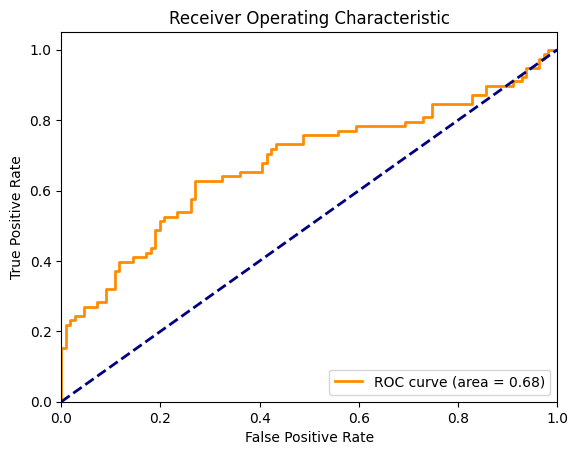

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y1, prob)
roc_auc = auc(fpr, tpr)

# Построение ROC кривой
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

**Banknote Dataset**

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
import pandas as pd
from sklearn.metrics import roc_auc_score

data_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"
data = pd.read_csv(data_url, header=None)
data_matrix = data.values

n = 700
y = data_matrix[1:701, 4]
X = data_matrix[1:701, :4]

r = 2
N = 100

d = X.shape[1]

# Фиксированные параметры
mu_0 = 0.0
mu_w_0 = 2.0
lambda_w_0 = 3.0
gamma_0 = 1.0
alpha_lambda = 1.0
beta_lambda = 1.0

epsilon = 0.0001

mu_w_new = 0
mu_v_new = np.zeros(r)
lambda_w_new = 1
lambda_v_new = np.ones(r)

Theta_0 = 0
Theta_w = np.zeros(d)
Theta_v = np.zeros(d*r)
Beta = np.concatenate((np.array([Theta_0]), Theta_w, Theta_v, np.array([lambda_w_new, mu_w_new]), lambda_v_new, mu_v_new))
Beta = tf.expand_dims(tf.constant(Beta, dtype=tf.float64), axis=0)
Theta_v_matrix = tf.constant(np.reshape(Theta_v, (d, r)), dtype=tf.float64)


# Логарифм функции правдоподобия
def loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X):
    Beta_Theta_w = tf.expand_dims(Beta_Theta_w, axis=1)
    model = (Beta_Theta_0 + tf.matmul(X, Beta_Theta_w)) + 0.5 * tf.reduce_sum((tf.matmul(X, Beta_v_matrix))**2 - (X**2) @ (Beta_v_matrix**2), axis=1, keepdims=True)

    loglik_1 = tf.reduce_sum(tf.expand_dims(y, axis=1) * model)
    loglik_0 = tf.reduce_sum(tf.math.log1p(tf.exp(model)))

    loglik = loglik_1 - loglik_0
    return loglik

# Логарифм априорного распределения для Theta_H
def log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new):
    log_lambda_w = tf.cast(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_w_new), tf.float64)
    log_mu_w = tf.cast(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0*Beta_lambda_w_new))).log_prob(Beta_mu_w_new), tf.float64)
    log_lambda_v = tf.cast(tf.reduce_sum(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_v_new)), tf.float64)
    log_mu_v = tf.reduce_sum(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0 * Beta_lambda_v_new))).log_prob(Beta_mu_v_new))

    log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
    return log_theta_H

# Логарифм априорного распределения для Theta
def log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new):
    log_theta_0 = tfp.distributions.Normal(loc=tf.cast(mu_w_0, tf.float64), scale=tf.sqrt(1/tf.cast(lambda_w_0, tf.float64))).log_prob(tf.cast(Beta_Theta_0, tf.float64))
    log_theta_w = tf.reduce_sum(tfp.distributions.Normal(loc=tf.cast(Beta_mu_w_new, tf.float64), scale=tf.sqrt(1/tf.cast(Beta_lambda_w_new, tf.float64))).log_prob(tf.cast(Beta_Theta_w, tf.float64)))
    log_theta_v = tf.reduce_sum(tfp.distributions.Normal(loc=Beta_mu_v_new, scale=tf.sqrt(1/Beta_lambda_v_new)).log_prob(Beta_v_matrix))

    log_theta = log_theta_0 + log_theta_w + log_theta_v
    return log_theta


def log_prob_fn(Beta):
  # Логарифм функции правдоподобия для Beta
  loglik_Beta = loglik(Beta[0], Beta[1:d+1], Theta_v_matrix, y, X)
  # Логарифм априорного распределения для Theta_H для Beta
  log_theta_H_Beta = log_theta_H(lambda_w_new , alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
  # Логарифм априорного распределения для Theta для Beta
  log_theta_Beta = log_theta(Beta[0], mu_w_0, lambda_w_0, Beta[1:d+1], mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

  # Логарифм апостериорного распределения для Beta
  logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta

  return logpost_Beta

# Параметры HMC
step_size = epsilon
num_burnin_steps = 0
num_adaptation_steps = int(0.8 * num_burnin_steps)
num_samples = N

def run_sampler():
    initial_state = tf.zeros(1 + d + d*r + 2 + 2*r, dtype=tf.float64)
    # HMC ядро
    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=log_prob_fn,
        step_size=step_size,
        num_leapfrog_steps=10)

    # Адаптивный HMC
    adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=hmc_kernel,
        num_adaptation_steps=num_adaptation_steps,
        target_accept_prob=0.8)

    samples = tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        kernel=adaptive_hmc,
        trace_fn=None)
    return samples

# Запуск сессии и получение значений сэмплов
samples = run_sampler()
b_1 = np.mean(np.asarray(samples), axis=0)
V = np.matrix(b_1[(d + 1):(d + 1 + d * r)]).reshape(d, r, order='C')

X1 = data_matrix[701:1372,:4]
y1 = data_matrix[701:1372,4]

D = 0.5 * tf.reduce_sum((tf.matmul(X1, V))**2 - (X1**2) @ np.square(V), axis=1, keepdims=True)
b_1 = tf.expand_dims(tf.constant(b_1, dtype=tf.float64), axis=1)
prob = 1 /(1 + tf.exp(-(b_1[0] + tf.matmul(X1, b_1[1:(d+1)]) + D)))

auc_roc = roc_auc_score(y1, prob)
print("AUC-ROC:", auc_roc)

AUC-ROC: 0.900429991937651


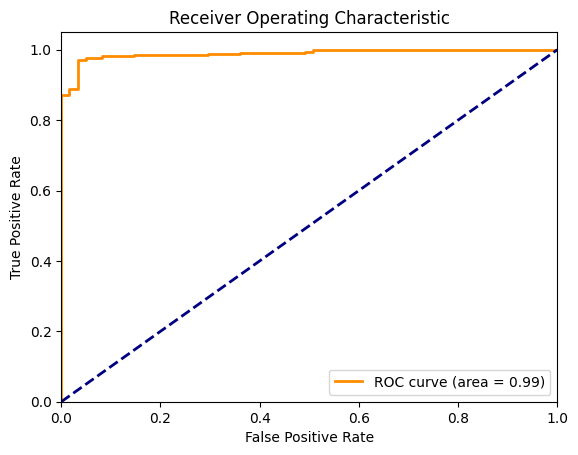

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y1, prob)
roc_auc = auc(fpr, tpr)

# Построение ROC кривой
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# **NUTS**

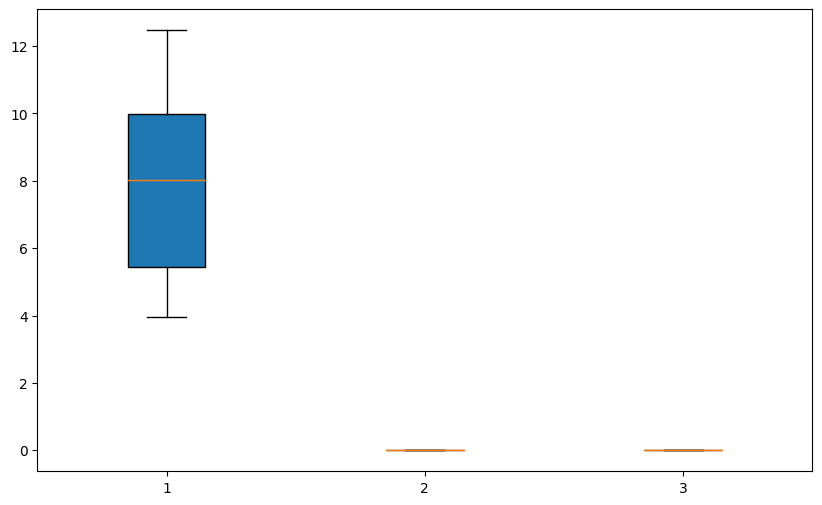

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

d = 2
r = 3
n = 500
M = 10

E = np.zeros(M)
Q = np.zeros((M, 3))

# Фиксированные параметры
mu_0 = 0.0
mu_w_0 = 2.0
lambda_w_0 = 3.0
gamma_0 = 1.0
alpha_lambda = 1.0
beta_lambda = 1.0

t = 0
epsilon = 0.0017

# Логарифм функции правдоподобия
def loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X):
    Beta_Theta_w = tf.expand_dims(Beta_Theta_w, axis=1)
    model = (Beta_Theta_0 + tf.matmul(X, Beta_Theta_w)) + 0.5 * tf.reduce_sum((tf.matmul(X, Beta_v_matrix))**2 - (X**2) @ (Beta_v_matrix**2), axis=1, keepdims=True)
    loglik_1 = tf.reduce_sum(tf.expand_dims(y, axis=1) * model)
    loglik_0 = tf.reduce_sum(tf.math.log1p(tf.exp(model)))

    loglik = loglik_1 - loglik_0
    return loglik

# Логарифм априорного распределения для Theta_H
def log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new):
    log_lambda_w = tf.cast(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_w_new), tf.float64)
    log_mu_w = tf.cast(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0*Beta_lambda_w_new))).log_prob(Beta_mu_w_new), tf.float64)
    log_lambda_v = tf.cast(tf.reduce_sum(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_v_new)), tf.float64)
    log_mu_v = tf.reduce_sum(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0 * Beta_lambda_v_new))).log_prob(Beta_mu_v_new))

    log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
    return log_theta_H

# Логарифм априорного распределения для Theta
def log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new):
    log_theta_0 = tfp.distributions.Normal(loc=tf.cast(mu_w_0, tf.float64), scale=tf.sqrt(1/tf.cast(lambda_w_0, tf.float64))).log_prob(tf.cast(Beta_Theta_0, tf.float64))
    log_theta_w = tf.reduce_sum(tfp.distributions.Normal(loc=tf.cast(Beta_mu_w_new, tf.float64), scale=tf.sqrt(1/tf.cast(Beta_lambda_w_new, tf.float64))).log_prob(tf.cast(Beta_Theta_w, tf.float64)))
    log_theta_v = tf.reduce_sum(tfp.distributions.Normal(loc=Beta_mu_v_new, scale=tf.sqrt(1/Beta_lambda_v_new)).log_prob(Beta_v_matrix))

    log_theta = log_theta_0 + log_theta_w + log_theta_v
    return log_theta


for N in [5]:
    for m in range(M):
        X = np.random.randn(n, d)
        # Параметры
        w_0 = np.random.normal(mu_w_0, np.sqrt(1/lambda_w_0))
        lambda_w = np.random.gamma(alpha_lambda, 1/beta_lambda)
        mu_w = np.random.normal(mu_0, np.sqrt(1/(gamma_0*lambda_w)))
        w = np.random.normal(mu_w, np.sqrt(1/lambda_w), d)
        lambda_v = np.random.gamma(alpha_lambda, 1/beta_lambda, r)
        mu_v = np.random.normal(mu_0, np.sqrt(1/(gamma_0*lambda_v)), r)
        v = np.random.normal(mu_v, np.sqrt(1/lambda_v), (d, r))

        # Beta_teor
        Beta_teor = np.concatenate((np.array([w_0]), w, v.flatten(), np.array([lambda_w, mu_w]), lambda_v, mu_v))
        Beta_teor = tf.expand_dims(tf.constant(Beta_teor, dtype=tf.float64), axis=0)

        doudle_Sum_teor = 0.5 * np.sum((X @ v)**2 - (X**2) @ (v**2), axis=1)
        p = expit(w_0 + X @ w + doudle_Sum_teor)
        y = np.random.binomial(1, p, n).astype(np.float64)

        mu_w_new = 0
        mu_v_new = np.zeros(r)
        lambda_w_new = 1
        lambda_v_new = np.ones(r)

        Theta_0 = 0
        Theta_w = np.zeros(d)
        Theta_v = np.zeros(d*r)
        Beta = np.concatenate((np.array([Theta_0]), Theta_w, Theta_v, np.array([lambda_w_new, mu_w_new]), lambda_v_new, mu_v_new))
        Beta = tf.expand_dims(tf.constant(Beta, dtype=tf.float64), axis=0)
        Theta_v_matrix = tf.constant(np.reshape(Theta_v, (d, r)), dtype=tf.float64)

        def log_prob_fn(Beta):
          # Логарифм функции правдоподобия для Beta
          loglik_Beta = loglik(Beta[0], Beta[1:d+1], Theta_v_matrix, y, X)
          # Логарифм априорного распределения для Theta_H для Beta
          log_theta_H_Beta = log_theta_H(lambda_w_new , alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
          # Логарифм априорного распределения для Theta для Beta
          log_theta_Beta = log_theta(Beta[0], mu_w_0, lambda_w_0, Beta[1:d+1], mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

          # Логарифм апостериорного распределения для Beta
          logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta
          return logpost_Beta

        # Параметры HMC
        step_size = epsilon
        num_burnin_steps = 0
        num_adaptation_steps = int(0.8 * num_burnin_steps)
        num_samples = N

        def run_sampler():
            initial_state = tf.zeros(1 + d + d*r + 2 + 2*r, dtype=tf.float64)

            # NUTS ядро
            nuts_kernel = tfp.mcmc.NoUTurnSampler(
                target_log_prob_fn=log_prob_fn,
                step_size=epsilon,
                max_tree_depth=10,
                max_energy_diff=1000)

            samples = tfp.mcmc.sample_chain(
                num_results=num_samples,
                num_burnin_steps=num_burnin_steps,
                current_state=initial_state,
                kernel=nuts_kernel,
                trace_fn=None)
            return samples

       # Запуск сессии и получение значений сэмплов
        samples = run_sampler()
        b_1 = np.mean(np.asarray(samples), axis=0)
        E[m] = np.sqrt(np.sum((Beta_teor - b_1)**2))

    Q[:, t] = E
    t += 1

# Создание boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(Q, patch_artist=True)

# Отображение графика
plt.show()


# **MALA algorithm**

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
import pandas as pd
from sklearn.metrics import roc_auc_score

d = 2
r = 3
n = 500
M = 100

E = np.zeros(M)
Z = np.zeros((M, 3))

# Фиксированные параметры
mu_0 = 0.0
mu_w_0 = 2.0
lambda_w_0 = 3.0
gamma_0 = 1.0
alpha_lambda = 1.0
beta_lambda = 1.0

t = 0
epsilon = 0.017
sigma2 = epsilon**2 / (1+d+d*r+2+2*r)**(1 / 3)

# Логарифм функции правдоподобия
def loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X):
    Beta_Theta_w = tf.expand_dims(Beta_Theta_w, axis=1)
    model = (Beta_Theta_0 + tf.matmul(X, Beta_Theta_w)) + 0.5 * tf.reduce_sum((tf.matmul(X, Beta_v_matrix))**2 - (X**2) @ (Beta_v_matrix**2), axis=1, keepdims=True)
    loglik_1 = tf.reduce_sum(tf.expand_dims(y, axis=1) * model)
    loglik_0 = tf.reduce_sum(tf.math.log1p(tf.exp(model)))

    loglik = loglik_1 - loglik_0
    return loglik

# Логарифм априорного распределения для Theta_H
def log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new):
    log_lambda_w = tf.cast(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_w_new), tf.float64)
    log_mu_w = tf.cast(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0*Beta_lambda_w_new))).log_prob(Beta_mu_w_new), tf.float64)
    log_lambda_v = tf.cast(tf.reduce_sum(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_v_new)), tf.float64)
    log_mu_v = tf.reduce_sum(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0 * Beta_lambda_v_new))).log_prob(Beta_mu_v_new))

    log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
    return log_theta_H

# Логарифм априорного распределения для Theta
def log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new):
    log_theta_0 = tfp.distributions.Normal(loc=tf.cast(mu_w_0, tf.float64), scale=tf.sqrt(1/tf.cast(lambda_w_0, tf.float64))).log_prob(tf.cast(Beta_Theta_0, tf.float64))
    log_theta_w = tf.reduce_sum(tfp.distributions.Normal(loc=tf.cast(Beta_mu_w_new, tf.float64), scale=tf.sqrt(1/tf.cast(Beta_lambda_w_new, tf.float64))).log_prob(tf.cast(Beta_Theta_w, tf.float64)))
    log_theta_v = tf.reduce_sum(tfp.distributions.Normal(loc=Beta_mu_v_new, scale=tf.sqrt(1/Beta_lambda_v_new)).log_prob(Beta_v_matrix))

    log_theta = log_theta_0 + log_theta_w + log_theta_v
    return log_theta


for N in [50]:
    for m in range(M):
        X = np.random.randn(n, d)
        # Параметры
        w_0 = np.random.normal(mu_w_0, np.sqrt(1/lambda_w_0))
        lambda_w = np.random.gamma(alpha_lambda, 1/beta_lambda)
        mu_w = np.random.normal(mu_0, np.sqrt(1/(gamma_0*lambda_w)))
        w = np.random.normal(mu_w, np.sqrt(1/lambda_w), d)
        lambda_v = np.random.gamma(alpha_lambda, 1/beta_lambda, r)
        mu_v = np.random.normal(mu_0, np.sqrt(1/(gamma_0*lambda_v)), r)
        v = np.random.normal(mu_v, np.sqrt(1/lambda_v), (d, r))

        # Beta_teor
        Beta_teor = np.concatenate((np.array([w_0]), w, v.flatten(), np.array([lambda_w, mu_w]), lambda_v, mu_v))
        Beta_teor = tf.expand_dims(tf.constant(Beta_teor, dtype=tf.float64), axis=0)

        doudle_Sum_teor = 0.5 * np.sum((X @ v)**2 - (X**2) @ (v**2), axis=1)
        p = expit(w_0 + X @ w + doudle_Sum_teor)
        y = np.random.binomial(1, p, n).astype(np.float64)

        mu_w_new = 0
        mu_v_new = np.zeros(r)
        lambda_w_new = 1
        lambda_v_new = np.ones(r)

        Theta_0 = 0
        Theta_w = np.zeros(d)
        Theta_v = np.zeros(d*r)
        Beta = np.concatenate((np.array([Theta_0]), Theta_w, Theta_v, np.array([lambda_w_new, mu_w_new]), lambda_v_new, mu_v_new))
        Beta = tf.expand_dims(tf.constant(Beta, dtype=tf.float64), axis=0)
        Theta_v_matrix = tf.constant(np.reshape(Theta_v, (d, r)), dtype=tf.float64)

        def log_prob_fn(Beta):
          # Логарифм функции правдоподобия для Beta
          loglik_Beta = loglik(Beta[0], Beta[1:d+1], Theta_v_matrix, y, X)
          # Логарифм априорного распределения для Theta_H для Beta
          log_theta_H_Beta = log_theta_H(lambda_w_new , alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
          # Логарифм априорного распределения для Theta для Beta
          log_theta_Beta = log_theta(Beta[0], mu_w_0, lambda_w_0, Beta[1:d+1], mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

          # Логарифм апостериорного распределения для Beta
          logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta
          return logpost_Beta

        # Параметры MCMC
        num_burnin_steps = 0
        num_adaptation_steps = int(0.8 * num_burnin_steps)
        num_samples = N

        # Вычисление цепочки сэмплов внутри сессии
        def run_sampler():
            initial_state = tf.zeros(1 + d + d*r + 2 + 2*r, dtype=tf.float64)
            # Создание MetropolisAdjustedLangevinAlgorithm
            mala_kernel = tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(
            target_log_prob_fn=log_prob_fn,
            step_size= sigma2)


            # Вычисление цепочки сэмплов
            samples = tfp.mcmc.sample_chain(
                num_results=num_samples,
                num_burnin_steps=num_burnin_steps,
                current_state=initial_state,
                kernel=mala_kernel,
                trace_fn=None)
            return samples

        # Запуск сессии и получение значений сэмплов
        samples = run_sampler()
        b_1 = np.mean(np.asarray(samples), axis=0)
        E[m] = np.sqrt(np.sum((Beta_teor - b_1)**2))

    Z[:, t] = E
    t += 1


# Создание boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(Z, patch_artist=True)

# Отображение графика
plt.show()


KeyboardInterrupt: 

# **MALA algorithm (небольшая размерность)**

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

d = 2
r = 3
n = 500
M = 10

E = np.zeros(M)
Z = np.zeros((M, 3))

# Фиксированные параметры
mu_0 = 0.0
mu_w_0 = 2.0
lambda_w_0 = 3.0
gamma_0 = 1.0
alpha_lambda = 1.0
beta_lambda = 1.0

t = 0
epsilon = 0.017
sigma2 = epsilon**2 / (1+d+d*r+2+2*r)**(1 / 3)

# Логарифм функции правдоподобия
def loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X):
    Beta_Theta_w = tf.expand_dims(Beta_Theta_w, axis=1)
    model = (Beta_Theta_0 + tf.matmul(X, Beta_Theta_w)) + 0.5 * tf.reduce_sum((tf.matmul(X, Beta_v_matrix))**2 - (X**2) @ (Beta_v_matrix**2), axis=1, keepdims=True)
    loglik_1 = tf.reduce_sum(tf.expand_dims(y, axis=1) * model)
    loglik_0 = tf.reduce_sum(tf.math.log1p(tf.exp(model)))

    loglik = loglik_1 - loglik_0
    return loglik

# Логарифм априорного распределения для Theta_H
def log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new):
    log_lambda_w = tf.cast(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_w_new), tf.float64)
    log_mu_w = tf.cast(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0*Beta_lambda_w_new))).log_prob(Beta_mu_w_new), tf.float64)
    log_lambda_v = tf.cast(tf.reduce_sum(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_v_new)), tf.float64)
    log_mu_v = tf.reduce_sum(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0 * Beta_lambda_v_new))).log_prob(Beta_mu_v_new))

    log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
    return log_theta_H

# Логарифм априорного распределения для Theta
def log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new):
    log_theta_0 = tfp.distributions.Normal(loc=tf.cast(mu_w_0, tf.float64), scale=tf.sqrt(1/tf.cast(lambda_w_0, tf.float64))).log_prob(tf.cast(Beta_Theta_0, tf.float64))
    log_theta_w = tf.reduce_sum(tfp.distributions.Normal(loc=tf.cast(Beta_mu_w_new, tf.float64), scale=tf.sqrt(1/tf.cast(Beta_lambda_w_new, tf.float64))).log_prob(tf.cast(Beta_Theta_w, tf.float64)))
    log_theta_v = tf.reduce_sum(tfp.distributions.Normal(loc=Beta_mu_v_new, scale=tf.sqrt(1/Beta_lambda_v_new)).log_prob(Beta_v_matrix))

    log_theta = log_theta_0 + log_theta_w + log_theta_v
    return log_theta


for N in [5]:
    for m in range(M):
        X = np.random.randn(n, d)
        # Параметры
        w_0 = np.random.normal(mu_w_0, np.sqrt(1/lambda_w_0))
        lambda_w = np.random.gamma(alpha_lambda, 1/beta_lambda)
        mu_w = np.random.normal(mu_0, np.sqrt(1/(gamma_0*lambda_w)))
        w = np.random.normal(mu_w, np.sqrt(1/lambda_w), d)
        lambda_v = np.random.gamma(alpha_lambda, 1/beta_lambda, r)
        mu_v = np.random.normal(mu_0, np.sqrt(1/(gamma_0*lambda_v)), r)
        v = np.random.normal(mu_v, np.sqrt(1/lambda_v), (d, r))

        # Beta_teor
        Beta_teor = np.concatenate((np.array([w_0]), w, v.flatten(), np.array([lambda_w, mu_w]), lambda_v, mu_v))
        Beta_teor = tf.expand_dims(tf.constant(Beta_teor, dtype=tf.float64), axis=0)

        doudle_Sum_teor = 0.5 * np.sum((X @ v)**2 - (X**2) @ (v**2), axis=1)
        p = expit(w_0 + X @ w + doudle_Sum_teor)
        y = np.random.binomial(1, p, n).astype(np.float64)

        mu_w_new = 0
        mu_v_new = np.zeros(r)
        lambda_w_new = 1
        lambda_v_new = np.ones(r)

        Theta_0 = 0
        Theta_w = np.zeros(d)
        Theta_v = np.zeros(d*r)
        Beta = np.concatenate((np.array([Theta_0]), Theta_w, Theta_v, np.array([lambda_w_new, mu_w_new]), lambda_v_new, mu_v_new))
        Beta = tf.expand_dims(tf.constant(Beta, dtype=tf.float64), axis=0)
        Theta_v_matrix = tf.constant(np.reshape(Theta_v, (d, r)), dtype=tf.float64)

        def log_prob_fn(Beta):
          # Логарифм функции правдоподобия для Beta
          loglik_Beta = loglik(Beta[0], Beta[1:d+1], Theta_v_matrix, y, X)
          # Логарифм априорного распределения для Theta_H для Beta
          log_theta_H_Beta = log_theta_H(lambda_w_new , alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
          # Логарифм априорного распределения для Theta для Beta
          log_theta_Beta = log_theta(Beta[0], mu_w_0, lambda_w_0, Beta[1:d+1], mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

          # Логарифм апостериорного распределения для Beta
          logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta
          return logpost_Beta

        # Параметры MCMC
        num_burnin_steps = 0
        num_adaptation_steps = int(0.8 * num_burnin_steps)
        num_samples = N

        # Вычисление цепочки сэмплов внутри сессии
        def run_sampler():
            initial_state = tf.zeros(1 + d + d*r + 2 + 2*r, dtype=tf.float64)
            # Создание MetropolisAdjustedLangevinAlgorithm
            mala_kernel = tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(
            target_log_prob_fn=log_prob_fn,
            step_size= sigma2)


            # Вычисление цепочки сэмплов
            samples = tfp.mcmc.sample_chain(
                num_results=num_samples,
                num_burnin_steps=num_burnin_steps,
                current_state=initial_state,
                kernel=mala_kernel,
                trace_fn=None)
            return samples

        # Запуск сессии и получение значений сэмплов
        samples = run_sampler()
        b_1 = np.mean(np.asarray(samples), axis=0)
        E[m] = np.sqrt(np.sum((Beta_teor - b_1)**2))

    Z[:, t] = E
    t += 1

print(samples)
print("Среднее по матрице", b_1)

tf.Tensor(
[[ 0.0111109  -0.00656594  0.00734918  0.01210842  0.0037892   0.0013804
   0.02150534 -0.01012912 -0.01051776 -0.02010024 -0.00431988 -0.0004425
   0.00398625 -0.02607796 -0.01291178  0.00834228 -0.00512434]
 [ 0.03725996 -0.0131395   0.01555955  0.01520233  0.00434552 -0.01228303
   0.03754552 -0.00485505 -0.00085467 -0.01458418  0.01067141  0.0038334
   0.01721005 -0.03996863 -0.0070028   0.01025866 -0.00554706]
 [ 0.04862942 -0.01949257  0.02099504  0.00638386 -0.00366992 -0.01377439
   0.0364383   0.0088122   0.00101264 -0.01433068  0.01138033  0.00942015
   0.02047794 -0.03073482 -0.00472397  0.00909021 -0.01760129]
 [ 0.08020094 -0.02962936  0.01989532  0.00069674 -0.00201419 -0.00828452
   0.04112305  0.00733131  0.01119653 -0.02171992  0.00356016  0.014719
   0.03326295 -0.04595332 -0.01129714  0.00162748 -0.03721412]
 [ 0.07578586 -0.02603299  0.02973377 -0.00147716  0.00388903  0.00477229
   0.03908339  0.02410158  0.00543272 -0.01557963  0.00465945  0.01465606
  

# **Datasets (MALA)**

**Pima Indians Diabetes Dataset**

In [ ]:
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

data = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv", header=None)
data_matrix = data.values

X = data_matrix[1:501, :8]
y = data_matrix[1:501, 8]
y = np.squeeze(y)

d = X.shape[1]

n = 500
r = 3
N = 100

# Фиксированные параметры
mu_0 = 0.0
mu_w_0 = 2.0
lambda_w_0 = 3.0
gamma_0 = 1.0
alpha_lambda = 1.0
beta_lambda = 1.0

epsilon = 0.001
sigma2 = epsilon**2 / (1+d+d*r+2+2*r)**(1 / 3)

mu_w_new = 0
mu_v_new = np.zeros(r)
lambda_w_new = 1
lambda_v_new = np.ones(r)

Theta_0 = 0
Theta_w = np.zeros(d)
Theta_v = np.zeros(d*r)
Beta = np.concatenate((np.array([Theta_0]), Theta_w, Theta_v, np.array([lambda_w_new, mu_w_new]), lambda_v_new, mu_v_new))
Beta = tf.expand_dims(tf.constant(Beta, dtype=tf.float64), axis=0)
Theta_v_matrix = tf.constant(np.reshape(Theta_v, (d, r)), dtype=tf.float64)


# Логарифм функции правдоподобия
def loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X):
    Beta_Theta_w = tf.expand_dims(Beta_Theta_w, axis=1)
    model = (Beta_Theta_0 + tf.matmul(X, Beta_Theta_w)) + 0.5 * tf.reduce_sum((tf.matmul(X, Beta_v_matrix))**2 - (X**2) @ (Beta_v_matrix**2), axis=1, keepdims=True)
    loglik_1 = tf.reduce_sum(tf.expand_dims(y, axis=1) * model)
    loglik_0 = tf.reduce_sum(tf.math.log1p(tf.exp(model)))

    loglik = loglik_1 - loglik_0
    return loglik

# Логарифм априорного распределения для Theta_H
def log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new):
    log_lambda_w = tf.cast(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_w_new), tf.float64)
    log_mu_w = tf.cast(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0*Beta_lambda_w_new))).log_prob(Beta_mu_w_new), tf.float64)
    log_lambda_v = tf.cast(tf.reduce_sum(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_v_new)), tf.float64)
    log_mu_v = tf.reduce_sum(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0 * Beta_lambda_v_new))).log_prob(Beta_mu_v_new))

    log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
    return log_theta_H

# Логарифм априорного распределения для Theta
def log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new):
    log_theta_0 = tfp.distributions.Normal(loc=tf.cast(mu_w_0, tf.float64), scale=tf.sqrt(1/tf.cast(lambda_w_0, tf.float64))).log_prob(tf.cast(Beta_Theta_0, tf.float64))
    log_theta_w = tf.reduce_sum(tfp.distributions.Normal(loc=tf.cast(Beta_mu_w_new, tf.float64), scale=tf.sqrt(1/tf.cast(Beta_lambda_w_new, tf.float64))).log_prob(tf.cast(Beta_Theta_w, tf.float64)))
    log_theta_v = tf.reduce_sum(tfp.distributions.Normal(loc=Beta_mu_v_new, scale=tf.sqrt(1/Beta_lambda_v_new)).log_prob(Beta_v_matrix))

    log_theta = log_theta_0 + log_theta_w + log_theta_v
    return log_theta


def log_prob_fn(Beta):
  # Логарифм функции правдоподобия для Beta
  loglik_Beta = loglik(Beta[0], Beta[1:d+1], Theta_v_matrix, y, X)
  # Логарифм априорного распределения для Theta_H для Beta
  log_theta_H_Beta = log_theta_H(lambda_w_new , alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
  # Логарифм априорного распределения для Theta для Beta
  log_theta_Beta = log_theta(Beta[0], mu_w_0, lambda_w_0, Beta[1:d+1], mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

  # Логарифм апостериорного распределения для Beta
  logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta

  return logpost_Beta

# Параметры MCMC
num_burnin_steps = 0
num_adaptation_steps = int(0.8 * num_burnin_steps)
num_samples = N

# Вычисление цепочки сэмплов внутри сессии
def run_sampler():
    initial_state = tf.zeros(1 + d + d*r + 2 + 2*r, dtype=tf.float64)
    # Создание MetropolisAdjustedLangevinAlgorithm
    mala_kernel = tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(
    target_log_prob_fn=log_prob_fn,
    step_size= sigma2)


    # Вычисление цепочки сэмплов
    samples = tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        kernel=mala_kernel,
        trace_fn=None)
    return samples

# Запуск сессии и получение значений сэмплов
samples = run_sampler()
b_1 = np.mean(np.asarray(samples), axis=0)

V = np.matrix(b_1[(d + 1):(d + 1 + d * r)]).reshape(d, r, order='C')

X1 = data_matrix[501:769, :8]
y1 = data_matrix[501:769, 8]

D = 0.5 * tf.reduce_sum((tf.matmul(X1, V))**2 - (X1**2) @ np.square(V), axis=1, keepdims=True)
b_1 = tf.expand_dims(tf.constant(b_1, dtype=tf.float64), axis=1)
prob = 1 /(1 + tf.exp(-(b_1[0] + tf.matmul(X1, b_1[1:(d+1)]) + D)))

auc_roc = roc_auc_score(y1, prob)
print("AUC-ROC:", auc_roc)


NameError: name 'roc_auc_score' is not defined

In [ ]:
X

array([[1.00e+00, 8.50e+01, 6.60e+01, ..., 2.66e+01, 3.51e-01, 3.10e+01],
       [8.00e+00, 1.83e+02, 6.40e+01, ..., 2.33e+01, 6.72e-01, 3.20e+01],
       [1.00e+00, 8.90e+01, 6.60e+01, ..., 2.81e+01, 1.67e-01, 2.10e+01],
       ...,
       [7.00e+00, 1.95e+02, 7.00e+01, ..., 2.51e+01, 1.63e-01, 5.50e+01],
       [6.00e+00, 1.54e+02, 7.40e+01, ..., 2.93e+01, 8.39e-01, 3.90e+01],
       [2.00e+00, 1.17e+02, 9.00e+01, ..., 2.52e+01, 3.13e-01, 2.10e+01]])

In [ ]:
y

array([0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
       0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       0., 0., 0., 0., 0.

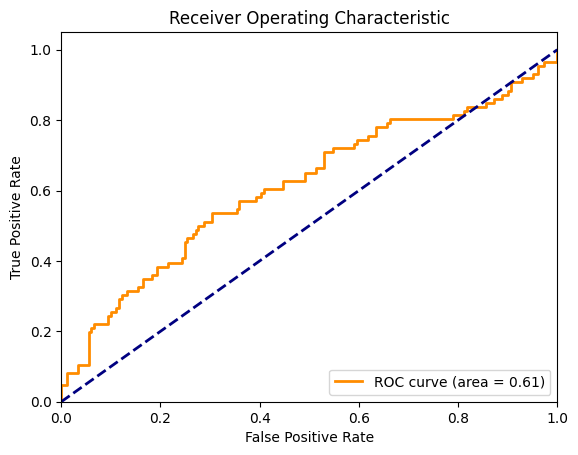

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y1, prob)
roc_auc = auc(fpr, tpr)

# Построение ROC кривой
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

**Sonar Dataset**

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data", header=None)
ind = np.random.permutation(207)
data = data.iloc[ind]

n = 120
r = 2
N = 100

data_new = data.iloc[:121, :]
X = data_new .iloc[1:, :60].values
y = (data_new .iloc[1:, 60] == 'R').astype(np.float64).values

d = X.shape[1]

# Фиксированные параметры
mu_0 = 0.0
mu_w_0 = 2.0
lambda_w_0 = 3.0
gamma_0 = 1.0
alpha_lambda = 1.0
beta_lambda = 1.0

epsilon = 0.09
sigma2 = epsilon**2 / (1+d+d*r+2+2*r)**(1 / 3)

mu_w_new = 0
mu_v_new = np.zeros(r)
lambda_w_new = 1
lambda_v_new = np.ones(r)

Theta_0 = 0
Theta_w = np.zeros(d)
Theta_v = np.zeros(d*r)
Beta = np.concatenate((np.array([Theta_0]), Theta_w, Theta_v, np.array([lambda_w_new, mu_w_new]), lambda_v_new, mu_v_new))
Beta = tf.expand_dims(tf.constant(Beta, dtype=tf.float64), axis=0)
Theta_v_matrix = tf.constant(np.reshape(Theta_v, (d, r)), dtype=tf.float64)


# Логарифм функции правдоподобия
def loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X):
    Beta_Theta_w = tf.expand_dims(Beta_Theta_w, axis=1)
    model = (Beta_Theta_0 + tf.matmul(X, Beta_Theta_w)) + 0.5 * tf.reduce_sum((tf.matmul(X, Beta_v_matrix))**2 - (X**2) @ (Beta_v_matrix**2), axis=1, keepdims=True)
    loglik_1 = tf.reduce_sum(tf.expand_dims(y, axis=1) * model)
    loglik_0 = tf.reduce_sum(tf.math.log1p(tf.exp(model)))

    loglik = loglik_1 - loglik_0
    return loglik

# Логарифм априорного распределения для Theta_H
def log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new):
    log_lambda_w = tf.cast(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_w_new), tf.float64)
    log_mu_w = tf.cast(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0*Beta_lambda_w_new))).log_prob(Beta_mu_w_new), tf.float64)
    log_lambda_v = tf.cast(tf.reduce_sum(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_v_new)), tf.float64)
    log_mu_v = tf.reduce_sum(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0 * Beta_lambda_v_new))).log_prob(Beta_mu_v_new))

    log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
    return log_theta_H

# Логарифм априорного распределения для Theta
def log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new):
    log_theta_0 = tfp.distributions.Normal(loc=tf.cast(mu_w_0, tf.float64), scale=tf.sqrt(1/tf.cast(lambda_w_0, tf.float64))).log_prob(tf.cast(Beta_Theta_0, tf.float64))
    log_theta_w = tf.reduce_sum(tfp.distributions.Normal(loc=tf.cast(Beta_mu_w_new, tf.float64), scale=tf.sqrt(1/tf.cast(Beta_lambda_w_new, tf.float64))).log_prob(tf.cast(Beta_Theta_w, tf.float64)))
    log_theta_v = tf.reduce_sum(tfp.distributions.Normal(loc=Beta_mu_v_new, scale=tf.sqrt(1/Beta_lambda_v_new)).log_prob(Beta_v_matrix))

    log_theta = log_theta_0 + log_theta_w + log_theta_v
    return log_theta


def log_prob_fn(Beta):
  # Логарифм функции правдоподобия для Beta
  loglik_Beta = loglik(Beta[0], Beta[1:d+1], Theta_v_matrix, y, X)
  # Логарифм априорного распределения для Theta_H для Beta
  log_theta_H_Beta = log_theta_H(lambda_w_new , alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
  # Логарифм априорного распределения для Theta для Beta
  log_theta_Beta = log_theta(Beta[0], mu_w_0, lambda_w_0, Beta[1:d+1], mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

  # Логарифм апостериорного распределения для Beta
  logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta
  return logpost_Beta

# Параметры MCMC
num_burnin_steps = 0
num_adaptation_steps = int(0.8 * num_burnin_steps)
num_samples = N

# Вычисление цепочки сэмплов внутри сессии
def run_sampler():
    initial_state = tf.zeros(1 + d + d*r + 2 + 2*r, dtype=tf.float64)
    # Создание MetropolisAdjustedLangevinAlgorithm
    mala_kernel = tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(
    target_log_prob_fn=log_prob_fn,
    step_size= sigma2)


    # Вычисление цепочки сэмплов
    samples = tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        kernel=mala_kernel,
        trace_fn=None)
    return samples

# Запуск сессии и получение значений сэмплов
samples = run_sampler()
b_1 = np.mean(np.asarray(samples), axis=0)

V = np.matrix(b_1[(d + 1):(d + 1 + d * r)]).reshape(d, r, order='C')

X1 = data.iloc[121:208, :60].values
X1 = np.matrix(X1)
y1 = (data.iloc[121:208, 60] == 'R').astype(np.float64).values
y1 = np.array(y1)


D = 0.5 * tf.reduce_sum((tf.matmul(X1, V))**2 - np.square(X1) @ np.square(V), axis=1, keepdims=True)
b_1 = tf.expand_dims(tf.constant(b_1, dtype=tf.float64), axis=1)
prob = 1 /(1 + tf.exp(-(b_1[0] + tf.matmul(X1, b_1[1:(d+1)]) + D)))

auc_roc = roc_auc_score(y1, prob)
print("AUC-ROC:", auc_roc)


AUC-ROC: 0.591869918699187


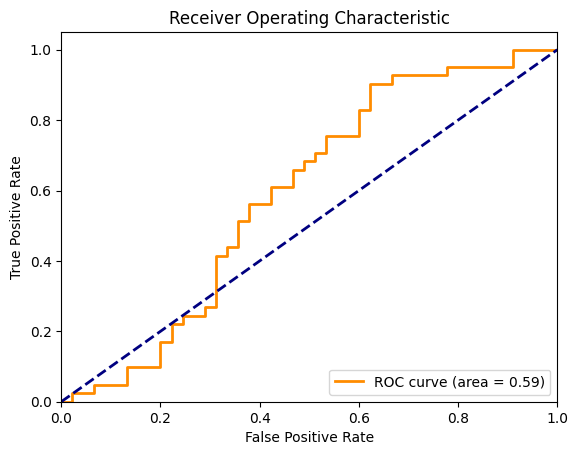

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y1, prob)
roc_auc = auc(fpr, tpr)

# Построение ROC кривой
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

**Australian Credit Approval DataSet**

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/australian/australian.dat"
data = pd.read_csv(data_url, sep=' ', header=None, na_values='?', skipinitialspace=True)
data = data.dropna().values

n = 500
y = data[1:501, 14]
X = data[1:501, :14]

r = 3
N = 100

d = X.shape[1]

# Фиксированные параметры
mu_0 = 0.0
mu_w_0 = 2.0
lambda_w_0 = 3.0
gamma_0 = 1.0
alpha_lambda = 1.0
beta_lambda = 1.0

epsilon =0.0001
sigma2 = epsilon**2 / (1+d+d*r+2+2*r)**(1 / 3)

mu_w_new = 0
mu_v_new = np.zeros(r)
lambda_w_new = 1
lambda_v_new = np.ones(r)

Theta_0 = 0
Theta_w = np.zeros(d)
Theta_v = np.zeros(d*r)
Beta = np.concatenate((np.array([Theta_0]), Theta_w, Theta_v, np.array([lambda_w_new, mu_w_new]), lambda_v_new, mu_v_new))
Beta = tf.expand_dims(tf.constant(Beta, dtype=tf.float64), axis=0)
Theta_v_matrix = tf.constant(np.reshape(Theta_v, (d, r)), dtype=tf.float64)


# Логарифм функции правдоподобия
def loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X):
    Beta_Theta_w = tf.expand_dims(Beta_Theta_w, axis=1)
    model = (Beta_Theta_0 + tf.matmul(X, Beta_Theta_w)) + 0.5 * tf.reduce_sum((tf.matmul(X, Beta_v_matrix))**2 - (X**2) @ (Beta_v_matrix**2), axis=1, keepdims=True)
    loglik_1 = tf.reduce_sum(tf.expand_dims(y, axis=1) * model)
    loglik_0 = tf.reduce_sum(tf.math.log1p(tf.exp(model)))

    loglik = loglik_1 - loglik_0
    return loglik

# Логарифм априорного распределения для Theta_H
def log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new):
    log_lambda_w = tf.cast(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_w_new), tf.float64)
    log_mu_w = tf.cast(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0*Beta_lambda_w_new))).log_prob(Beta_mu_w_new), tf.float64)
    log_lambda_v = tf.cast(tf.reduce_sum(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_v_new)), tf.float64)
    log_mu_v = tf.reduce_sum(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0 * Beta_lambda_v_new))).log_prob(Beta_mu_v_new))

    log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
    return log_theta_H

# Логарифм априорного распределения для Theta
def log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new):
    log_theta_0 = tfp.distributions.Normal(loc=tf.cast(mu_w_0, tf.float64), scale=tf.sqrt(1/tf.cast(lambda_w_0, tf.float64))).log_prob(tf.cast(Beta_Theta_0, tf.float64))
    log_theta_w = tf.reduce_sum(tfp.distributions.Normal(loc=tf.cast(Beta_mu_w_new, tf.float64), scale=tf.sqrt(1/tf.cast(Beta_lambda_w_new, tf.float64))).log_prob(tf.cast(Beta_Theta_w, tf.float64)))
    log_theta_v = tf.reduce_sum(tfp.distributions.Normal(loc=Beta_mu_v_new, scale=tf.sqrt(1/Beta_lambda_v_new)).log_prob(Beta_v_matrix))

    log_theta = log_theta_0 + log_theta_w + log_theta_v
    return log_theta


def log_prob_fn(Beta):
  # Логарифм функции правдоподобия для Beta
  loglik_Beta = loglik(Beta[0], Beta[1:d+1], Theta_v_matrix, y, X)
  # Логарифм априорного распределения для Theta_H для Beta
  log_theta_H_Beta = log_theta_H(lambda_w_new , alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
  # Логарифм априорного распределения для Theta для Beta
  log_theta_Beta = log_theta(Beta[0], mu_w_0, lambda_w_0, Beta[1:d+1], mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

  # Логарифм апостериорного распределения для Beta
  logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta
  return logpost_Beta

# Параметры MCMC
num_burnin_steps = 0
num_adaptation_steps = int(0.8 * num_burnin_steps)
num_samples = N

# Вычисление цепочки сэмплов внутри сессии
def run_sampler():
    initial_state = tf.zeros(1 + d + d*r + 2 + 2*r, dtype=tf.float64)
    # Создание MetropolisAdjustedLangevinAlgorithm
    mala_kernel = tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(
    target_log_prob_fn=log_prob_fn,
    step_size= sigma2)


    # Вычисление цепочки сэмплов
    samples = tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        kernel=mala_kernel,
        trace_fn=None)
    return samples

# Запуск сессии и получение значений сэмплов
samples = run_sampler()
b_1 = np.mean(np.asarray(samples), axis=0)

V = np.matrix(b_1[(d + 1):(d + 1 + d * r)]).reshape(d, r, order='C')

X1 = data[501:690,:14]
y1 = data[501:690,14]


D = 0.5 * tf.reduce_sum((tf.matmul(X1, V))**2 - np.square(X1) @ np.square(V), axis=1, keepdims=True)
b_1 = tf.expand_dims(tf.constant(b_1, dtype=tf.float64), axis=1)
prob = 1 /(1 + tf.exp(-(b_1[0] + tf.matmul(X1, b_1[1:(d+1)]) + D)))

auc_roc = roc_auc_score(y1, prob)
print("AUC-ROC:", auc_roc)


AUC-ROC: 0.6851466851466852


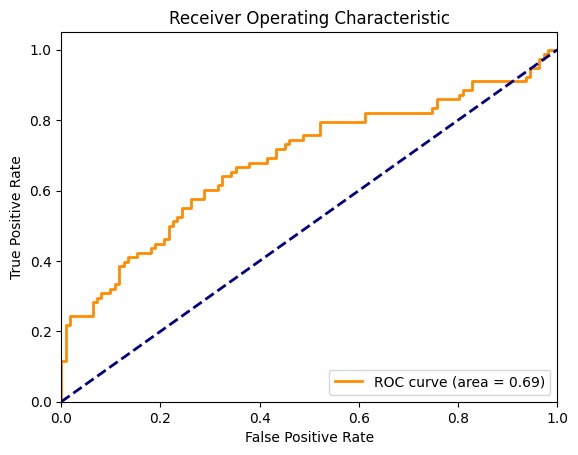

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y1, prob)
roc_auc = auc(fpr, tpr)

# Построение ROC кривой
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

**Banknote Dataset**

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

data_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"
data = pd.read_csv(data_url, header=None)
data_matrix = data.values

n = 700
y = data_matrix[1:701, 4]
X = data_matrix[1:701, :4]

r = 2
N = 100

d = X.shape[1]

# Фиксированные параметры
mu_0 = 0.0
mu_w_0 = 2.0
lambda_w_0 = 3.0
gamma_0 = 1.0
alpha_lambda = 1.0
beta_lambda = 1.0

epsilon = 0.01
sigma2 = epsilon**2 / (1+d+d*r+2+2*r)**(1 / 3)

mu_w_new = 0
mu_v_new = np.zeros(r)
lambda_w_new = 1
lambda_v_new = np.ones(r)

Theta_0 = 0
Theta_w = np.zeros(d)
Theta_v = np.zeros(d*r)
Beta = np.concatenate((np.array([Theta_0]), Theta_w, Theta_v, np.array([lambda_w_new, mu_w_new]), lambda_v_new, mu_v_new))
Beta = tf.expand_dims(tf.constant(Beta, dtype=tf.float64), axis=0)
Theta_v_matrix = tf.constant(np.reshape(Theta_v, (d, r)), dtype=tf.float64)


# Логарифм функции правдоподобия
def loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X):
    Beta_Theta_w = tf.expand_dims(Beta_Theta_w, axis=1)
    model = (Beta_Theta_0 + tf.matmul(X, Beta_Theta_w)) + 0.5 * tf.reduce_sum((tf.matmul(X, Beta_v_matrix))**2 - (X**2) @ (Beta_v_matrix**2), axis=1, keepdims=True)
    loglik_1 = tf.reduce_sum(tf.expand_dims(y, axis=1) * model)
    loglik_0 = tf.reduce_sum(tf.math.log1p(tf.exp(model)))

    loglik = loglik_1 - loglik_0
    return loglik

# Логарифм априорного распределения для Theta_H
def log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new):
    log_lambda_w = tf.cast(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_w_new), tf.float64)
    log_mu_w = tf.cast(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0*Beta_lambda_w_new))).log_prob(Beta_mu_w_new), tf.float64)
    log_lambda_v = tf.cast(tf.reduce_sum(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_v_new)), tf.float64)
    log_mu_v = tf.reduce_sum(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0 * Beta_lambda_v_new))).log_prob(Beta_mu_v_new))

    log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
    return log_theta_H

# Логарифм априорного распределения для Theta
def log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new):
    log_theta_0 = tfp.distributions.Normal(loc=tf.cast(mu_w_0, tf.float64), scale=tf.sqrt(1/tf.cast(lambda_w_0, tf.float64))).log_prob(tf.cast(Beta_Theta_0, tf.float64))
    log_theta_w = tf.reduce_sum(tfp.distributions.Normal(loc=tf.cast(Beta_mu_w_new, tf.float64), scale=tf.sqrt(1/tf.cast(Beta_lambda_w_new, tf.float64))).log_prob(tf.cast(Beta_Theta_w, tf.float64)))
    log_theta_v = tf.reduce_sum(tfp.distributions.Normal(loc=Beta_mu_v_new, scale=tf.sqrt(1/Beta_lambda_v_new)).log_prob(Beta_v_matrix))

    log_theta = log_theta_0 + log_theta_w + log_theta_v
    return log_theta


def log_prob_fn(Beta):
  # Логарифм функции правдоподобия для Beta
  loglik_Beta = loglik(Beta[0], Beta[1:d+1], Theta_v_matrix, y, X)
  # Логарифм априорного распределения для Theta_H для Beta
  log_theta_H_Beta = log_theta_H(lambda_w_new , alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
  # Логарифм априорного распределения для Theta для Beta
  log_theta_Beta = log_theta(Beta[0], mu_w_0, lambda_w_0, Beta[1:d+1], mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

  # Логарифм апостериорного распределения для Beta
  logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta
  return logpost_Beta

# Параметры MCMC
num_burnin_steps = 0
num_adaptation_steps = int(0.8 * num_burnin_steps)
num_samples = N

# Вычисление цепочки сэмплов внутри сессии
def run_sampler():
    initial_state = tf.zeros(1 + d + d*r + 2 + 2*r, dtype=tf.float64)
    # Создание MetropolisAdjustedLangevinAlgorithm
    mala_kernel = tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(
    target_log_prob_fn=log_prob_fn,
    step_size= sigma2)


    # Вычисление цепочки сэмплов
    samples = tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        kernel=mala_kernel,
        trace_fn=None)
    return samples

# Запуск сессии и получение значений сэмплов
samples = run_sampler()
b_1 = np.mean(np.asarray(samples), axis=0)

V = np.matrix(b_1[(d + 1):(d + 1 + d * r)]).reshape(d, r, order='C')

X1 = data_matrix[701:1372,:4]
y1 = data_matrix[701:1372,4]

D = 0.5 * tf.reduce_sum((tf.matmul(X1, V))**2 - np.square(X1) @ np.square(V), axis=1, keepdims=True)
b_1 = tf.expand_dims(tf.constant(b_1, dtype=tf.float64), axis=1)
prob = 1 /(1 + tf.exp(-(b_1[0] + tf.matmul(X1, b_1[1:(d+1)]) + D)))

auc_roc = roc_auc_score(y1, prob)
print("AUC-ROC:", auc_roc)

AUC-ROC: 0.9893308250470303


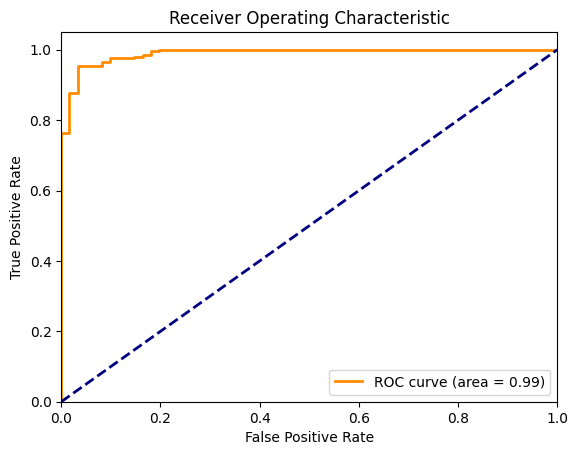

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y1, prob)
roc_auc = auc(fpr, tpr)

# Построение ROC кривой
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# **Cтандартный алгоритм Метрополиса-Гастингса**

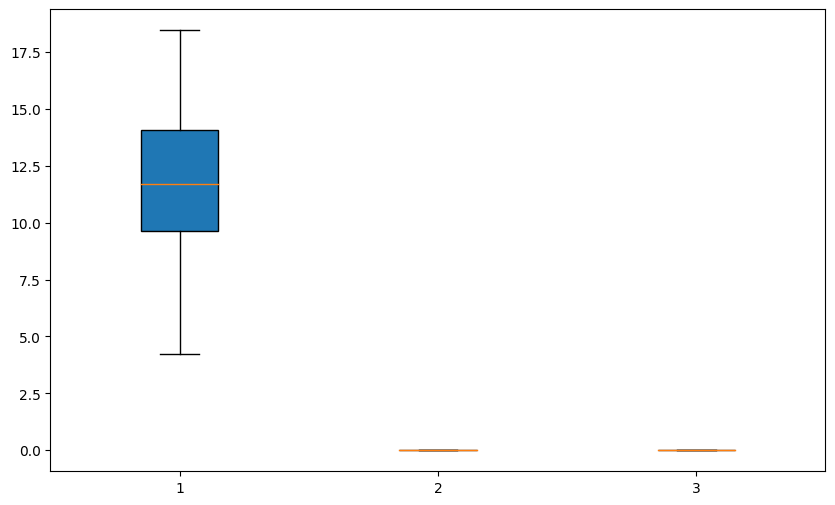

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

d = 2
r = 3
n = 500
M = 100

E = np.zeros(M)
Z = np.zeros((M, 3))

# Фиксированные параметры
mu_0 = 0.0
mu_w_0 = 2.0
lambda_w_0 = 3.0
gamma_0 = 1.0
alpha_lambda = 1.0
beta_lambda = 1.0

t = 0

# Логарифм функции правдоподобия
def loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X):
    Beta_Theta_w = tf.expand_dims(Beta_Theta_w, axis=1)
    model = (Beta_Theta_0 + tf.matmul(X, Beta_Theta_w)) + 0.5 * tf.reduce_sum((tf.matmul(X, Beta_v_matrix))**2 - (X**2) @ (Beta_v_matrix**2), axis=1, keepdims=True)
    loglik_1 = tf.reduce_sum(tf.expand_dims(y, axis=1) * model)
    loglik_0 = tf.reduce_sum(tf.math.log1p(tf.exp(model)))

    loglik = loglik_1 - loglik_0
    return loglik

# Логарифм априорного распределения для Theta_H
def log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new):
    log_lambda_w = tf.cast(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_w_new), tf.float64)
    log_mu_w = tf.cast(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0*Beta_lambda_w_new))).log_prob(Beta_mu_w_new), tf.float64)
    log_lambda_v = tf.cast(tf.reduce_sum(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_v_new)), tf.float64)
    log_mu_v = tf.reduce_sum(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0 * Beta_lambda_v_new))).log_prob(Beta_mu_v_new))

    log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
    return log_theta_H

# Логарифм априорного распределения для Theta
def log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new):
    log_theta_0 = tfp.distributions.Normal(loc=tf.cast(mu_w_0, tf.float64), scale=tf.sqrt(1/tf.cast(lambda_w_0, tf.float64))).log_prob(tf.cast(Beta_Theta_0, tf.float64))
    log_theta_w = tf.reduce_sum(tfp.distributions.Normal(loc=tf.cast(Beta_mu_w_new, tf.float64), scale=tf.sqrt(1/tf.cast(Beta_lambda_w_new, tf.float64))).log_prob(tf.cast(Beta_Theta_w, tf.float64)))
    log_theta_v = tf.reduce_sum(tfp.distributions.Normal(loc=Beta_mu_v_new, scale=tf.sqrt(1/Beta_lambda_v_new)).log_prob(Beta_v_matrix))

    log_theta = log_theta_0 + log_theta_w + log_theta_v
    return log_theta


for N in [500]:
    for m in range(M):
        X = np.random.randn(n, d)
        # Параметры
        w_0 = np.random.normal(mu_w_0, np.sqrt(1/lambda_w_0))
        lambda_w = np.random.gamma(alpha_lambda, 1/beta_lambda)
        mu_w = np.random.normal(mu_0, np.sqrt(1/(gamma_0*lambda_w)))
        w = np.random.normal(mu_w, np.sqrt(1/lambda_w), d)
        lambda_v = np.random.gamma(alpha_lambda, 1/beta_lambda, r)
        mu_v = np.random.normal(mu_0, np.sqrt(1/(gamma_0*lambda_v)), r)
        v = np.random.normal(mu_v, np.sqrt(1/lambda_v), (d, r))

        # Beta_teor
        Beta_teor = np.concatenate((np.array([w_0]), w, v.flatten(), np.array([lambda_w, mu_w]), lambda_v, mu_v))
        Beta_teor = tf.expand_dims(tf.constant(Beta_teor, dtype=tf.float64), axis=0)

        doudle_Sum_teor = 0.5 * np.sum((X @ v)**2 - (X**2) @ (v**2), axis=1)
        p = expit(w_0 + X @ w + doudle_Sum_teor)
        y = np.random.binomial(1, p, n).astype(np.float64)

        mu_w_new = 0
        mu_v_new = np.zeros(r)
        lambda_w_new = 1
        lambda_v_new = np.ones(r)

        Theta_0 = 0
        Theta_w = np.zeros(d)
        Theta_v = np.zeros(d*r)
        Beta = np.concatenate((np.array([Theta_0]), Theta_w, Theta_v, np.array([lambda_w_new, mu_w_new]), lambda_v_new, mu_v_new))
        Beta = tf.expand_dims(tf.constant(Beta, dtype=tf.float64), axis=0)
        Theta_v_matrix = tf.constant(np.reshape(Theta_v, (d, r)), dtype=tf.float64)

        def log_prob_fn(Beta):
          # Логарифм функции правдоподобия для Beta
          loglik_Beta = loglik(Beta[0], Beta[1:d+1], Theta_v_matrix, y, X)
          # Логарифм априорного распределения для Theta_H для Beta
          log_theta_H_Beta = log_theta_H(lambda_w_new , alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
          # Логарифм априорного распределения для Theta для Beta
          log_theta_Beta = log_theta(Beta[0], mu_w_0, lambda_w_0, Beta[1:d+1], mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

          # Логарифм апостериорного распределения для Beta
          logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta
          return logpost_Beta

        # Параметры MCMC
        num_burnin_steps = 0
        num_samples = N
        initial_state = tf.zeros(1 + d + d*r + 2 + 2*r, dtype=tf.float64)

        # Создание RandomWalkMetropolis
        def new_state_fn(current_state, seed):
            return current_state + tf.random.normal(tf.shape(current_state), dtype=tf.float64)

        mh_kernel = tfp.mcmc.RandomWalkMetropolis(
            target_log_prob_fn=log_prob_fn,
            new_state_fn=new_state_fn
        )

        # Вычисление цепочки сэмплов
        samples = tfp.mcmc.sample_chain(
            num_results=num_samples,
            current_state=initial_state,
            kernel=mh_kernel,
            num_burnin_steps=num_burnin_steps,
            trace_fn=None)

        b_1 = np.mean(np.asarray(samples), axis=0)
        E[m] = np.sqrt(np.sum((Beta_teor - b_1)**2))

    Z[:, t] = E
    t += 1

# Создание boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(Z, patch_artist=True)

# Отображение графика
plt.show()

# **Cтандартный алгоритм Метрополиса-Гастингса (небольшая размерность)**

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

d = 2
r = 3
n = 500
M = 10

E = np.zeros(M)
Z = np.zeros((M, 3))

# Фиксированные параметры
mu_0 = 0.0
mu_w_0 = 2.0
lambda_w_0 = 3.0
gamma_0 = 1.0
alpha_lambda = 1.0
beta_lambda = 1.0

t = 0

# Логарифм функции правдоподобия
def loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X):
    Beta_Theta_w = tf.expand_dims(Beta_Theta_w, axis=1)
    model = (Beta_Theta_0 + tf.matmul(X, Beta_Theta_w)) + 0.5 * tf.reduce_sum((tf.matmul(X, Beta_v_matrix))**2 - (X**2) @ (Beta_v_matrix**2), axis=1, keepdims=True)
    loglik_1 = tf.reduce_sum(tf.expand_dims(y, axis=1) * model)
    loglik_0 = tf.reduce_sum(tf.math.log1p(tf.exp(model)))

    loglik = loglik_1 - loglik_0
    return loglik

# Логарифм априорного распределения для Theta_H
def log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new):
    log_lambda_w = tf.cast(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_w_new), tf.float64)
    log_mu_w = tf.cast(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0*Beta_lambda_w_new))).log_prob(Beta_mu_w_new), tf.float64)
    log_lambda_v = tf.cast(tf.reduce_sum(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_v_new)), tf.float64)
    log_mu_v = tf.reduce_sum(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0 * Beta_lambda_v_new))).log_prob(Beta_mu_v_new))

    log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
    return log_theta_H

# Логарифм априорного распределения для Theta
def log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new):
    log_theta_0 = tfp.distributions.Normal(loc=tf.cast(mu_w_0, tf.float64), scale=tf.sqrt(1/tf.cast(lambda_w_0, tf.float64))).log_prob(tf.cast(Beta_Theta_0, tf.float64))
    log_theta_w = tf.reduce_sum(tfp.distributions.Normal(loc=tf.cast(Beta_mu_w_new, tf.float64), scale=tf.sqrt(1/tf.cast(Beta_lambda_w_new, tf.float64))).log_prob(tf.cast(Beta_Theta_w, tf.float64)))
    log_theta_v = tf.reduce_sum(tfp.distributions.Normal(loc=Beta_mu_v_new, scale=tf.sqrt(1/Beta_lambda_v_new)).log_prob(Beta_v_matrix))

    log_theta = log_theta_0 + log_theta_w + log_theta_v
    return log_theta


for N in [50]:
    for m in range(M):
        X = np.random.randn(n, d)
        # Параметры
        w_0 = np.random.normal(mu_w_0, np.sqrt(1/lambda_w_0))
        lambda_w = np.random.gamma(alpha_lambda, 1/beta_lambda)
        mu_w = np.random.normal(mu_0, np.sqrt(1/(gamma_0*lambda_w)))
        w = np.random.normal(mu_w, np.sqrt(1/lambda_w), d)
        lambda_v = np.random.gamma(alpha_lambda, 1/beta_lambda, r)
        mu_v = np.random.normal(mu_0, np.sqrt(1/(gamma_0*lambda_v)), r)
        v = np.random.normal(mu_v, np.sqrt(1/lambda_v), (d, r))

        # Beta_teor
        Beta_teor = np.concatenate((np.array([w_0]), w, v.flatten(), np.array([lambda_w, mu_w]), lambda_v, mu_v))
        Beta_teor = tf.expand_dims(tf.constant(Beta_teor, dtype=tf.float64), axis=0)

        doudle_Sum_teor = 0.5 * np.sum((X @ v)**2 - (X**2) @ (v**2), axis=1)
        p = expit(w_0 + X @ w + doudle_Sum_teor)
        y = np.random.binomial(1, p, n).astype(np.float64)

        mu_w_new = 0
        mu_v_new = np.zeros(r)
        lambda_w_new = 1
        lambda_v_new = np.ones(r)

        Theta_0 = 0
        Theta_w = np.zeros(d)
        Theta_v = np.zeros(d*r)
        Beta = np.concatenate((np.array([Theta_0]), Theta_w, Theta_v, np.array([lambda_w_new, mu_w_new]), lambda_v_new, mu_v_new))
        Beta = tf.expand_dims(tf.constant(Beta, dtype=tf.float64), axis=0)
        Theta_v_matrix = tf.constant(np.reshape(Theta_v, (d, r)), dtype=tf.float64)

        def log_prob_fn(Beta):
          # Логарифм функции правдоподобия для Beta
          loglik_Beta = loglik(Beta[0], Beta[1:d+1], Theta_v_matrix, y, X)
          # Логарифм априорного распределения для Theta_H для Beta
          log_theta_H_Beta = log_theta_H(lambda_w_new , alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
          # Логарифм априорного распределения для Theta для Beta
          log_theta_Beta = log_theta(Beta[0], mu_w_0, lambda_w_0, Beta[1:d+1], mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

          # Логарифм апостериорного распределения для Beta
          logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta
          return logpost_Beta

        # Параметры MCMC
        num_burnin_steps = 0
        num_samples = N
        initial_state = tf.zeros(1 + d + d*r + 2 + 2*r, dtype=tf.float64)

        # Создание RandomWalkMetropolis
        def new_state_fn(current_state, seed):
            return current_state + tf.random.normal(tf.shape(current_state), dtype=tf.float64)

        mh_kernel = tfp.mcmc.RandomWalkMetropolis(
            target_log_prob_fn=log_prob_fn,
            new_state_fn=new_state_fn
        )

        # Вычисление цепочки сэмплов
        samples = tfp.mcmc.sample_chain(
            num_results=num_samples,
            current_state=initial_state,
            kernel=mh_kernel,
            num_burnin_steps=num_burnin_steps,
            trace_fn=None)

        b_1 = np.mean(np.asarray(samples), axis=0)
        E[m] = np.sqrt(np.sum((Beta_teor - b_1)**2))

    Z[:, t] = E
    t += 1

print(samples)
print("Среднее по матрице", b_1)

tf.Tensor(
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.         

# **Datasets (Cтандартный алгоритм Метрополиса-Гастингса)**

**Pima Indians Diabetes Dataset**

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
import pandas as pd
from sklearn.metrics import roc_auc_score

tfd = tfp.distributions

data = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv", header=None)
data_matrix = data.values

X = data_matrix[1:501, :8]
y = data_matrix[1:501, 8].astype(np.float64)
y = np.squeeze(y)

d = X.shape[1]

n = 500
r = 3
N = 100

# Фиксированные параметры
mu_0 = 0.0
mu_w_0 = 2.0
lambda_w_0 = 3.0
gamma_0 = 1.0
alpha_lambda = 1.0
beta_lambda = 1.0

mu_w_new = 0
mu_v_new = np.zeros(r)
lambda_w_new = 1
lambda_v_new = np.ones(r)

Theta_0 = 0
Theta_w = np.zeros(d)
Theta_v = np.zeros(d*r)
Beta = np.concatenate((np.array([Theta_0]), Theta_w, Theta_v, np.array([lambda_w_new, mu_w_new]), lambda_v_new, mu_v_new))
Beta = tf.expand_dims(tf.constant(Beta, dtype=tf.float64), axis=0)
Theta_v_matrix = tf.constant(np.reshape(Theta_v, (d, r)), dtype=tf.float64)

sigma = 1.0
V = sigma * np.eye(1+d+d*r+2+2*r, dtype=np.float64)
# Оптимальное значение opt_prop из текста
lambda_val = 2.38
opt_prop = (lambda_val**2 / (1+d+d*r+2+2*r)) * V

# Логарифм функции правдоподобия
def loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X):
    Beta_Theta_w = tf.expand_dims(Beta_Theta_w, axis=1)
    model = (Beta_Theta_0 + tf.matmul(X, Beta_Theta_w)) + 0.5 * tf.reduce_sum((tf.matmul(X, Beta_v_matrix))**2 - (X**2) @ (Beta_v_matrix**2), axis=1, keepdims=True)
    loglik_1 = tf.reduce_sum(tf.expand_dims(y, axis=1) * model)
    loglik_0 = tf.reduce_sum(tf.math.log1p(tf.exp(model)))

    loglik = loglik_1 - loglik_0
    return loglik

# Логарифм априорного распределения для Theta_H
def log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new):
    log_lambda_w = tf.cast(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_w_new), tf.float64)
    log_mu_w = tf.cast(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0*Beta_lambda_w_new))).log_prob(Beta_mu_w_new), tf.float64)
    log_lambda_v = tf.cast(tf.reduce_sum(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_v_new)), tf.float64)
    log_mu_v = tf.reduce_sum(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0 * Beta_lambda_v_new))).log_prob(Beta_mu_v_new))

    log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
    return log_theta_H

# Логарифм априорного распределения для Theta
def log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new):
    log_theta_0 = tfp.distributions.Normal(loc=tf.cast(mu_w_0, tf.float64), scale=tf.sqrt(1/tf.cast(lambda_w_0, tf.float64))).log_prob(tf.cast(Beta_Theta_0, tf.float64))
    log_theta_w = tf.reduce_sum(tfp.distributions.Normal(loc=tf.cast(Beta_mu_w_new, tf.float64), scale=tf.sqrt(1/tf.cast(Beta_lambda_w_new, tf.float64))).log_prob(tf.cast(Beta_Theta_w, tf.float64)))
    log_theta_v = tf.reduce_sum(tfp.distributions.Normal(loc=Beta_mu_v_new, scale=tf.sqrt(1/Beta_lambda_v_new)).log_prob(Beta_v_matrix))

    log_theta = log_theta_0 + log_theta_w + log_theta_v
    return log_theta


def log_prob_fn(Beta):
  # Логарифм функции правдоподобия для Beta
  loglik_Beta = loglik(Beta[0], Beta[1:d+1], Theta_v_matrix, y, X)
  # Логарифм априорного распределения для Theta_H для Beta
  log_theta_H_Beta = log_theta_H(lambda_w_new , alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
  # Логарифм априорного распределения для Theta для Beta
  log_theta_Beta = log_theta(Beta[0], mu_w_0, lambda_w_0, Beta[1:d+1], mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

  # Логарифм апостериорного распределения для Beta
  logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta
  return logpost_Beta

# Параметры MCMC
num_burnin_steps = 0
num_samples = N
initial_state = tf.zeros(1 + d + d*r + 2 + 2*r, dtype=tf.float64)

# Создание RandomWalkMetropolis
def new_state_fn(current_state, seed=None):
  new_state_dist = tfd.MultivariateNormalFullCovariance(
      loc=current_state,
      covariance_matrix=opt_prop
  )
  new_state = new_state_dist.sample(seed=seed)
  return new_state

mh_kernel = tfp.mcmc.RandomWalkMetropolis(
    target_log_prob_fn=log_prob_fn,
    new_state_fn=new_state_fn
)
# Вычисление цепочки сэмплов
samples = tfp.mcmc.sample_chain(
    num_results=num_samples,
    current_state=initial_state,
    kernel=mh_kernel,
    num_burnin_steps=num_burnin_steps,
    trace_fn=None)

b_1 = np.mean(np.asarray(samples), axis=0)
V = np.matrix(b_1[(d + 1):(d + 1 + d * r)]).reshape(d, r, order='C')

X1 = data_matrix[501:769, :8]
y1 = data_matrix[501:769, 8].astype(np.float64)

D = 0.5 * tf.reduce_sum((tf.matmul(X1, V))**2 - np.square(X1) @ np.square(V), axis=1, keepdims=True)
b_1 = tf.expand_dims(tf.constant(b_1, dtype=tf.float64), axis=1)
prob = 1 /(1 + tf.exp(-(b_1[0] + tf.matmul(X1, b_1[1:(d+1)]) + D)))

auc_roc = roc_auc_score(y1, prob)
print("AUC-ROC:", auc_roc)


Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


AUC-ROC: 0.5


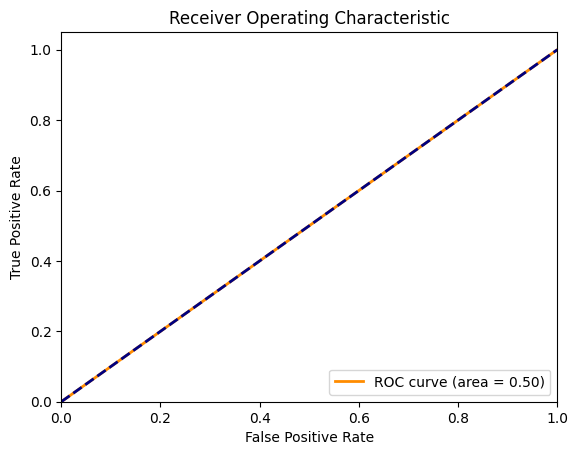

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y1, prob)
roc_auc = auc(fpr, tpr)

# Построение ROC кривой
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

**Sonar Dataset**

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
import pandas as pd
from sklearn.metrics import roc_auc_score

tfd = tfp.distributions

data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data", header=None)
ind = np.random.permutation(207)
data = data.iloc[ind]

n = 120
r = 2
N = 100

data_new = data.iloc[:121, :]
X = data_new .iloc[1:, :60].values  # Первые n строк и первые 60 столбцов, преобразуем в numpy array
y = (data_new .iloc[1:, 60] == 'R').astype(np.float64).values


d = X.shape[1]

# Фиксированные параметры
mu_0 = 0.0
mu_w_0 = 2.0
lambda_w_0 = 3.0
gamma_0 = 1.0
alpha_lambda = 1.0
beta_lambda = 1.0

mu_w_new = 0
mu_v_new = np.zeros(r)
lambda_w_new = 1
lambda_v_new = np.ones(r)

Theta_0 = 0
Theta_w = np.zeros(d)
Theta_v = np.zeros(d*r)
Beta = np.concatenate((np.array([Theta_0]), Theta_w, Theta_v, np.array([lambda_w_new, mu_w_new]), lambda_v_new, mu_v_new))
Beta = tf.expand_dims(tf.constant(Beta, dtype=tf.float64), axis=0)
Theta_v_matrix = tf.constant(np.reshape(Theta_v, (d, r)), dtype=tf.float64)

sigma = 1.0
V = sigma * np.eye(1+d+d*r+2+2*r, dtype=np.float64)
# Оптимальное значение opt_prop из текста
lambda_val = 2.38
opt_prop = (lambda_val**2 / (1+d+d*r+2+2*r)) * V

# Логарифм функции правдоподобия
def loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X):
    Beta_Theta_w = tf.expand_dims(Beta_Theta_w, axis=1)
    model = (Beta_Theta_0 + tf.matmul(X, Beta_Theta_w)) + 0.5 * tf.reduce_sum((tf.matmul(X, Beta_v_matrix))**2 - (X**2) @ (Beta_v_matrix**2), axis=1, keepdims=True)
    loglik_1 = tf.reduce_sum(tf.expand_dims(y, axis=1) * model)
    loglik_0 = tf.reduce_sum(tf.math.log1p(tf.exp(model)))

    loglik = loglik_1 - loglik_0
    return loglik

# Логарифм априорного распределения для Theta_H
def log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new):
    log_lambda_w = tf.cast(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_w_new), tf.float64)
    log_mu_w = tf.cast(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0*Beta_lambda_w_new))).log_prob(Beta_mu_w_new), tf.float64)
    log_lambda_v = tf.cast(tf.reduce_sum(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_v_new)), tf.float64)
    log_mu_v = tf.reduce_sum(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0 * Beta_lambda_v_new))).log_prob(Beta_mu_v_new))

    log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
    return log_theta_H

# Логарифм априорного распределения для Theta
def log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new):
    log_theta_0 = tfp.distributions.Normal(loc=tf.cast(mu_w_0, tf.float64), scale=tf.sqrt(1/tf.cast(lambda_w_0, tf.float64))).log_prob(tf.cast(Beta_Theta_0, tf.float64))
    log_theta_w = tf.reduce_sum(tfp.distributions.Normal(loc=tf.cast(Beta_mu_w_new, tf.float64), scale=tf.sqrt(1/tf.cast(Beta_lambda_w_new, tf.float64))).log_prob(tf.cast(Beta_Theta_w, tf.float64)))
    log_theta_v = tf.reduce_sum(tfp.distributions.Normal(loc=Beta_mu_v_new, scale=tf.sqrt(1/Beta_lambda_v_new)).log_prob(Beta_v_matrix))

    log_theta = log_theta_0 + log_theta_w + log_theta_v
    return log_theta


def log_prob_fn(Beta):
  # Логарифм функции правдоподобия для Beta
  loglik_Beta = loglik(Beta[0], Beta[1:d+1], Theta_v_matrix, y, X)
  # Логарифм априорного распределения для Theta_H для Beta
  log_theta_H_Beta = log_theta_H(lambda_w_new , alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
  # Логарифм априорного распределения для Theta для Beta
  log_theta_Beta = log_theta(Beta[0], mu_w_0, lambda_w_0, Beta[1:d+1], mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

  # Логарифм апостериорного распределения для Beta
  logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta
  return logpost_Beta

# Параметры MCMC
num_burnin_steps = 0
num_samples = N
initial_state = tf.zeros(1 + d + d*r + 2 + 2*r, dtype=tf.float64)

# Создание RandomWalkMetropolis
def new_state_fn(current_state, seed=None):
  new_state_dist = tfd.MultivariateNormalFullCovariance(
      loc=current_state,
      covariance_matrix=opt_prop
  )
  new_state = new_state_dist.sample(seed=seed)
  return new_state

mh_kernel = tfp.mcmc.RandomWalkMetropolis(
    target_log_prob_fn=log_prob_fn,
    new_state_fn=new_state_fn
)

# Вычисление цепочки сэмплов
samples = tfp.mcmc.sample_chain(
    num_results=num_samples,
    current_state=initial_state,
    kernel=mh_kernel,
    num_burnin_steps=num_burnin_steps,
    trace_fn=None)

b_1 = np.mean(np.asarray(samples), axis=0)
V = np.matrix(b_1[(d + 1):(d + 1 + d * r)]).reshape(d, r, order='C')

X1 = data.iloc[121:208, :60].values
X1 = np.matrix(X1)
y1 = (data.iloc[121:208, 60] == 'R').astype(np.float64).values
y1 = np.array(y1)

D = 0.5 * tf.reduce_sum((tf.matmul(X1, V))**2 - np.square(X1) @ np.square(V), axis=1, keepdims=True)
b_1 = tf.expand_dims(tf.constant(b_1, dtype=tf.float64), axis=1)
prob = 1 /(1 + tf.exp(-(b_1[0] + tf.matmul(X1, b_1[1:(d+1)]) + D)))

auc_roc = roc_auc_score(y1, prob)
print("AUC-ROC:", auc_roc)

AUC-ROC: 0.6425339366515838


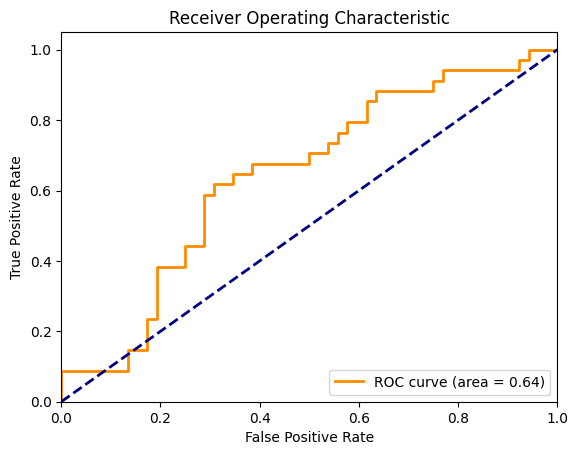

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y1, prob)
roc_auc = auc(fpr, tpr)

# Построение ROC кривой
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

**Australian Credit Approval DataSet**

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
import pandas as pd
from sklearn.metrics import roc_auc_score

tfd = tfp.distributions

data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/australian/australian.dat"
data = pd.read_csv(data_url, sep=' ', header=None, na_values='?', skipinitialspace=True)
data = data.dropna().values

n = 500
y = data[1:501, 14]
X = data[1:501, :14]

r = 3
N = 100
d = X.shape[1]

# Фиксированные параметры
mu_0 = 0.0
mu_w_0 = 2.0
lambda_w_0 = 3.0
gamma_0 = 1.0
alpha_lambda = 1.0
beta_lambda = 1.0

mu_w_new = 0
mu_v_new = np.zeros(r)
lambda_w_new = 1
lambda_v_new = np.ones(r)

Theta_0 = 0
Theta_w = np.zeros(d)
Theta_v = np.zeros(d*r)
Beta = np.concatenate((np.array([Theta_0]), Theta_w, Theta_v, np.array([lambda_w_new, mu_w_new]), lambda_v_new, mu_v_new))
Beta = tf.expand_dims(tf.constant(Beta, dtype=tf.float64), axis=0)
Theta_v_matrix = tf.constant(np.reshape(Theta_v, (d, r)), dtype=tf.float64)

sigma = 1.0
V = sigma * np.eye(1+d+d*r+2+2*r, dtype=np.float64)
# Оптимальное значение opt_prop из текста
lambda_val = 2.38
opt_prop = (lambda_val**2 / (1+d+d*r+2+2*r)) * V

# Логарифм функции правдоподобия
def loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X):
    Beta_Theta_w = tf.expand_dims(Beta_Theta_w, axis=1)
    model = (Beta_Theta_0 + tf.matmul(X, Beta_Theta_w)) + 0.5 * tf.reduce_sum((tf.matmul(X, Beta_v_matrix))**2 - (X**2) @ (Beta_v_matrix**2), axis=1, keepdims=True)
    loglik_1 = tf.reduce_sum(tf.expand_dims(y, axis=1) * model)
    loglik_0 = tf.reduce_sum(tf.math.log1p(tf.exp(model)))

    loglik = loglik_1 - loglik_0
    return loglik

# Логарифм априорного распределения для Theta_H
def log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new):
    log_lambda_w = tf.cast(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_w_new), tf.float64)
    log_mu_w = tf.cast(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0*Beta_lambda_w_new))).log_prob(Beta_mu_w_new), tf.float64)
    log_lambda_v = tf.cast(tf.reduce_sum(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_v_new)), tf.float64)
    log_mu_v = tf.reduce_sum(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0 * Beta_lambda_v_new))).log_prob(Beta_mu_v_new))

    log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
    return log_theta_H

# Логарифм априорного распределения для Theta
def log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new):
    log_theta_0 = tfp.distributions.Normal(loc=tf.cast(mu_w_0, tf.float64), scale=tf.sqrt(1/tf.cast(lambda_w_0, tf.float64))).log_prob(tf.cast(Beta_Theta_0, tf.float64))
    log_theta_w = tf.reduce_sum(tfp.distributions.Normal(loc=tf.cast(Beta_mu_w_new, tf.float64), scale=tf.sqrt(1/tf.cast(Beta_lambda_w_new, tf.float64))).log_prob(tf.cast(Beta_Theta_w, tf.float64)))
    log_theta_v = tf.reduce_sum(tfp.distributions.Normal(loc=Beta_mu_v_new, scale=tf.sqrt(1/Beta_lambda_v_new)).log_prob(Beta_v_matrix))

    log_theta = log_theta_0 + log_theta_w + log_theta_v
    return log_theta


def log_prob_fn(Beta):
  # Логарифм функции правдоподобия для Beta
  loglik_Beta = loglik(Beta[0], Beta[1:d+1], Theta_v_matrix, y, X)
  # Логарифм априорного распределения для Theta_H для Beta
  log_theta_H_Beta = log_theta_H(lambda_w_new , alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
  # Логарифм априорного распределения для Theta для Beta
  log_theta_Beta = log_theta(Beta[0], mu_w_0, lambda_w_0, Beta[1:d+1], mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

  # Логарифм апостериорного распределения для Beta
  logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta
  return logpost_Beta

# Параметры MCMC
num_burnin_steps = 0
num_samples = N
initial_state = tf.zeros(1 + d + d*r + 2 + 2*r, dtype=tf.float64)

# Создание RandomWalkMetropolis
def new_state_fn(current_state, seed=None):
  new_state_dist = tfd.MultivariateNormalFullCovariance(
      loc=current_state,
      covariance_matrix=opt_prop
  )
  new_state = new_state_dist.sample(seed=seed)
  return new_state

mh_kernel = tfp.mcmc.RandomWalkMetropolis(
    target_log_prob_fn=log_prob_fn,
    new_state_fn=new_state_fn
)
# Вычисление цепочки сэмплов
samples = tfp.mcmc.sample_chain(
    num_results=num_samples,
    current_state=initial_state,
    kernel=mh_kernel,
    num_burnin_steps=num_burnin_steps,
    trace_fn=None)

b_1 = np.mean(np.asarray(samples), axis=0)
V = np.matrix(b_1[(d + 1):(d + 1 + d * r)]).reshape(d, r, order='C')

X1 = data[501:690,:14]
y1 = data[501:690,14]


D = 0.5 * tf.reduce_sum((tf.matmul(X1, V))**2 - np.square(X1) @ np.square(V), axis=1, keepdims=True)
b_1 = tf.expand_dims(tf.constant(b_1, dtype=tf.float64), axis=1)
prob = 1 /(1 + tf.exp(-(b_1[0] + tf.matmul(X1, b_1[1:(d+1)]) + D)))

auc_roc = roc_auc_score(y1, prob)
print("AUC-ROC:", auc_roc)

AUC-ROC: 0.5


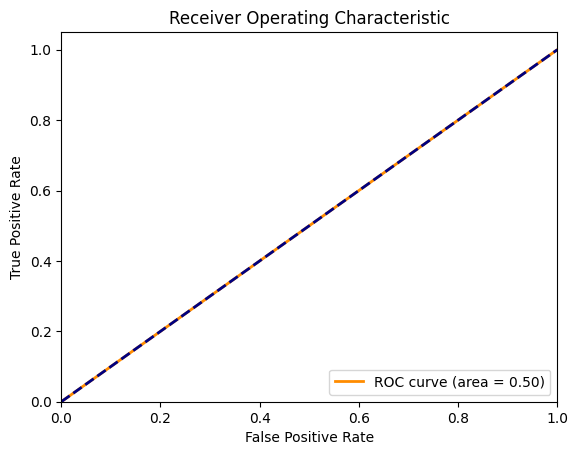

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y1, prob)
roc_auc = auc(fpr, tpr)

# Построение ROC кривой
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

**Banknote Dataset**

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
import pandas as pd
from sklearn.metrics import roc_auc_score

tfd = tfp.distributions

data_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"
data = pd.read_csv(data_url, header=None)
data_matrix = data.values

n = 700
y = data_matrix[1:701, 4]
X = data_matrix[1:701, :4]

r = 2
N = 100
d = X.shape[1]

# Фиксированные параметры
mu_0 = 0.0
mu_w_0 = 2.0
lambda_w_0 = 3.0
gamma_0 = 1.0
alpha_lambda = 1.0
beta_lambda = 1.0

mu_w_new = 0
mu_v_new = np.zeros(r)
lambda_w_new = 1
lambda_v_new = np.ones(r)

Theta_0 = 0
Theta_w = np.zeros(d)
Theta_v = np.zeros(d*r)
Beta = np.concatenate((np.array([Theta_0]), Theta_w, Theta_v, np.array([lambda_w_new, mu_w_new]), lambda_v_new, mu_v_new))
Beta = tf.expand_dims(tf.constant(Beta, dtype=tf.float64), axis=0)
Theta_v_matrix = tf.constant(np.reshape(Theta_v, (d, r)), dtype=tf.float64)

sigma = 1.0
V = sigma * np.eye(1+d+d*r+2+2*r, dtype=np.float64)
# Оптимальное значение opt_prop из текста
lambda_val = 0.5     #2.38
opt_prop = (lambda_val**2 / (1+d+d*r+2+2*r)) * V

# Логарифм функции правдоподобия
def loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X):
    Beta_Theta_w = tf.expand_dims(Beta_Theta_w, axis=1)
    model = (Beta_Theta_0 + tf.matmul(X, Beta_Theta_w)) + 0.5 * tf.reduce_sum((tf.matmul(X, Beta_v_matrix))**2 - (X**2) @ (Beta_v_matrix**2), axis=1, keepdims=True)
    loglik_1 = tf.reduce_sum(tf.expand_dims(y, axis=1) * model)
    loglik_0 = tf.reduce_sum(tf.math.log1p(tf.exp(model)))

    loglik = loglik_1 - loglik_0
    return loglik

# Логарифм априорного распределения для Theta_H
def log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new):
    log_lambda_w = tf.cast(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_w_new), tf.float64)
    log_mu_w = tf.cast(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0*Beta_lambda_w_new))).log_prob(Beta_mu_w_new), tf.float64)
    log_lambda_v = tf.cast(tf.reduce_sum(tfp.distributions.Gamma(concentration=alpha_lambda, rate=beta_lambda).log_prob(Beta_lambda_v_new)), tf.float64)
    log_mu_v = tf.reduce_sum(tfp.distributions.Normal(loc=mu_0, scale=tf.sqrt(1/(gamma_0 * Beta_lambda_v_new))).log_prob(Beta_mu_v_new))

    log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
    return log_theta_H

# Логарифм априорного распределения для Theta
def log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new):
    log_theta_0 = tfp.distributions.Normal(loc=tf.cast(mu_w_0, tf.float64), scale=tf.sqrt(1/tf.cast(lambda_w_0, tf.float64))).log_prob(tf.cast(Beta_Theta_0, tf.float64))
    log_theta_w = tf.reduce_sum(tfp.distributions.Normal(loc=tf.cast(Beta_mu_w_new, tf.float64), scale=tf.sqrt(1/tf.cast(Beta_lambda_w_new, tf.float64))).log_prob(tf.cast(Beta_Theta_w, tf.float64)))
    log_theta_v = tf.reduce_sum(tfp.distributions.Normal(loc=Beta_mu_v_new, scale=tf.sqrt(1/Beta_lambda_v_new)).log_prob(Beta_v_matrix))

    log_theta = log_theta_0 + log_theta_w + log_theta_v
    return log_theta


def log_prob_fn(Beta):
  # Логарифм функции правдоподобия для Beta
  loglik_Beta = loglik(Beta[0], Beta[1:d+1], Theta_v_matrix, y, X)
  # Логарифм априорного распределения для Theta_H для Beta
  log_theta_H_Beta = log_theta_H(lambda_w_new , alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
  # Логарифм априорного распределения для Theta для Beta
  log_theta_Beta = log_theta(Beta[0], mu_w_0, lambda_w_0, Beta[1:d+1], mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

  # Логарифм апостериорного распределения для Beta
  logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta
  return logpost_Beta

# Параметры MCMC
num_burnin_steps = 0
num_samples = N
initial_state = tf.zeros(1 + d + d*r + 2 + 2*r, dtype=tf.float64)

# Создание RandomWalkMetropolis
def new_state_fn(current_state, seed=None):
  new_state_dist = tfd.MultivariateNormalFullCovariance(
      loc=current_state,
      covariance_matrix=opt_prop
  )
  new_state = new_state_dist.sample(seed=seed)
  return new_state

mh_kernel = tfp.mcmc.RandomWalkMetropolis(
    target_log_prob_fn=log_prob_fn,
    new_state_fn=new_state_fn
)

# Вычисление цепочки сэмплов
samples = tfp.mcmc.sample_chain(
    num_results=num_samples,
    current_state=initial_state,
    kernel=mh_kernel,
    num_burnin_steps=num_burnin_steps,
    trace_fn=None)

b_1 = np.mean(np.asarray(samples), axis=0)
V = np.matrix(b_1[(d + 1):(d + 1 + d * r)]).reshape(d, r, order='C')

X1 = data_matrix[701:1372,:4]
y1 = data_matrix[701:1372,4]

D = 0.5 * tf.reduce_sum((tf.matmul(X1, V))**2 - np.square(X1) @ np.square(V), axis=1, keepdims=True)
b_1 = tf.expand_dims(tf.constant(b_1, dtype=tf.float64), axis=1)
prob = 1 /(1 + tf.exp(-(b_1[0] + tf.matmul(X1, b_1[1:(d+1)]) + D)))

auc_roc = roc_auc_score(y1, prob)
print("AUC-ROC:", auc_roc)

AUC-ROC: 0.8422467078742274


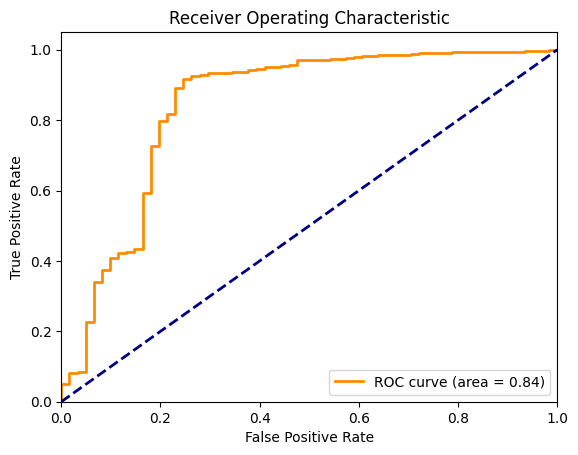

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y1, prob)
roc_auc = auc(fpr, tpr)

# Построение ROC кривой
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()